In [31]:
import pandas as pd
import csv
import io

# 原始数据
input_filename = 'Spotify_Dataset_V3.csv'
# 清洗后数据
output_filename = 'Spotify_Weekly_Data_Cleaned.csv'


def robust_clean_spotify_data(file_path):
    """
    最终版清洗流程:
    1. 使用 utf-8-sig 编码和 csv 模块进行健壮的解析.
    2. 将干净的数据加载到 pandas.
    3. 按 (歌曲, 周) 聚合.
    4. 对结果进行排序.
    """
    try:
        #1: 解析 CSV 文件 
        print("步骤1:开始以文本形式加载并使用csv模块解析")
        
        parsed_rows = []
        # 使用'utf-8-sig'来处理文件开头的BOM隐藏字符
        with open(file_path, 'r', encoding='utf-8-sig') as f:
            reader = csv.reader(f, delimiter=';', quotechar='"')
            for row in reader:
                parsed_rows.append(row)

        header = parsed_rows[0]
        cleaned_header = [col.split(',')[0].strip() for col in header]

        df = pd.DataFrame(parsed_rows[1:], columns=cleaned_header)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        df.dropna(axis=1, how='all', inplace=True)
        
        print(f"成功加载并解析文件, 原始数据形状: {df.shape}")
        print(f"解析后的列名: {df.columns.tolist()}")

        # 步骤2:数据类型转换和清理
        print("\n步骤2:开始进行数据类型转换和清理")

        df.rename(columns={'# of Artist': 'Artist_Rank_Str', '# of Nationality': 'Nationality_Rank_Str'}, inplace=True)
        
        if 'id' not in df.columns or 'Date' not in df.columns:
            raise ValueError("关键列'id'或'Date'不在数据中")

        # 将 'Date' 列转换为 datetime 对象
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

        numeric_cols = ['Rank', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 
                        'Acousticness', 'Instrumentalness', 'Valence', 'Points (Total)', 
                        'Points (Ind for each Artist/Nat)']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        df.dropna(subset=['id', 'Date'], inplace=True)
        print("数据类型转换完成")
        
        #  步骤3:转换数据形状 (按周和歌曲ID聚合)
        print("\n步骤 3: 开始转换数据形状 (按周聚合)")
        
        aggregation_rules = {
            'Rank': 'first', 'Title': 'first', 'Artists': 'first',
            'Danceability': 'first', 'Energy': 'first', 'Loudness': 'first', 'Speechiness': 'first',
            'Acousticness': 'first', 'Instrumentalness': 'first', 'Valence': 'first',
            'Points (Total)': 'first', 'Points (Ind for each Artist/Nat)': 'first', 'Song URL': 'first',
            'Artist (Ind.)': lambda x: list(x),
            'Nationality': lambda x: list(x),
            'Continent': lambda x: list(x),
        }

        # groupby自动按日期排序,
        df_weekly = df.groupby(['Date', 'id']).agg(aggregation_rules).reset_index()

        artist_counts = df.groupby(['Date', 'id']).size().reset_index(name='Artist_Count')
        nationality_counts = df.groupby(['Date', 'id'])['Nationality'].nunique().reset_index(name='Nationality_Count')

        df_weekly = pd.merge(df_weekly, artist_counts, on=['Date', 'id'])
        df_weekly = pd.merge(df_weekly, nationality_counts, on=['Date', 'id'])
        
        print(f"数据形状转换完成, 新数据形状: {df_weekly.shape}")

        #步骤 :清洗 Loudness列
        print("\n步骤4:开始修正Loudness列")

        def correct_loudness(loudness):
            if pd.isna(loudness): return None
            if loudness < -100: return loudness / 1000.0
            return loudness

        df_weekly['Loudness_Corrected'] = df_weekly['Loudness'].apply(correct_loudness)
        print("Loudness列修正完成。")
        
        # 进行最终排序数据
        print("\n步骤 5: 开始排序最终数据")
        # 首先按日期降序 (新日期在前), 然后在同一日期内按排名升序 (Rank 1 在前)
        df_weekly.sort_values(by=['Date', 'Rank'], ascending=[False, True], inplace=True)
        print("数据排序完成。")

        #保存数据 
        df_weekly.to_csv(output_filename, index=False, sep=';', encoding='utf-8-sig')
        print(f"\n清洗完成! 适合每周预测的数据已保存到 '{output_filename}'")
        
        return df_weekly

    except FileNotFoundError:
        print(f"错误: 文件 '{file_path}' 未找到。")
        return None
    except Exception as e:
        print(f"处理过程中发生了一个错误: {e}")
        return None

#主程序入口 
if __name__ == "__main__":
    cleaned_data = robust_clean_spotify_data(input_filename)
    if cleaned_data is not None:
        print("\n最终数据预览 (前5行):")
        pd.set_option('display.max_colwidth', 100)
        print(cleaned_data.head())


步骤1:开始以文本形式加载并使用csv模块解析
成功加载并解析文件, 原始数据形状: (651936, 20)
解析后的列名: ['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality', 'Nationality', 'Continent', 'Points (Total)', 'Points (Ind for each Artist/Nat)', 'id', 'Song URL']

步骤2:开始进行数据类型转换和清理
数据类型转换完成

步骤 3: 开始转换数据形状 (按周聚合)
数据形状转换完成, 新数据形状: (464475, 20)

步骤4:开始修正Loudness列
Loudness列修正完成。

步骤 5: 开始排序最终数据
数据排序完成。

清洗完成! 适合每周预测的数据已保存到 'Spotify_Weekly_Data_Cleaned.csv'

最终数据预览 (前5行):
             Date                      id  Rank              Title  \
464368 2023-05-29  3qQbCzHBycnDpGskqOWY0E   1.0    Ella Baila Sola   
464471 2023-05-29  7ro0hRteUMfnOioTFI5TG1   2.0     WHERE SHE GOES   
464341 2023-05-29  2UW7JaomAMuX9pZrjVpHAU   3.0    La Bebe - Remix   
464456 2023-05-29  7FbrGaHYVDmfr7KoLIZnQ7   4.0  Cupid - Twin Ver.   
464451 2023-05-29  6pD0ufEQq0xdHSsRbg9LBK   5.0          un x100to   

                 

In [32]:
import pandas as pd
import numpy as np
import ast

input_filename = 'Spotify_Weekly_Data_Cleaned.csv'
output_filename = 'Spotify_Model_Ready_Features_V2.csv'

def create_advanced_features(file_path):
    try:
        print("Step1:Loading weekly aggregated data")
        df = pd.read_csv(file_path, sep=';')
        
        #确保日期列是日期时间对象
        df['Date'] = pd.to_datetime(df['Date'])
        
        print(f"File loaded successfully. Shape: {df.shape}")
        print("\nStep2:Creating advanced features")

        #必须先按歌曲ID分组再按日期升序排序
        df.sort_values(by=['id', 'Date'], ascending=[True, True], inplace=True)
        
        # 第一个新特征创建歌曲生命周期特征上榜周数
        # cumcount函数是从零开始的累积计数加一后即为上榜周数
        df['Weeks_on_chart'] = df.groupby('id').cumcount() + 1
        print("Successfully created 'Weeks_on_chart' feature.")

        # 第二个新特征创建艺人热度特征这是一个多步骤的过程
        # 检查并转换艺人独立列
        # CSV读取时列表会变成字符串需要用此函数安全地转换回来
        if isinstance(df['Artist (Ind.)'].iloc[0], str):
            df['Artist (Ind.)'] = df['Artist (Ind.)'].apply(ast.literal_eval)
        
        # 展开数据框让每一行代表一个艺人歌曲周的组合
        artist_df = df[['Date', 'id', 'Artist (Ind.)', 'Points (Total)']].explode('Artist (Ind.)')

        # 计算每个艺人截至当前日期的历史平均分不包含当前周防止数据泄露
        artist_df.sort_values(['Artist (Ind.)', 'Date'], inplace=True)
        artist_df['artist_hist_avg'] = artist_df.groupby('Artist (Ind.)')['Points (Total)'].transform(
            lambda x: x.shift(1).expanding().mean()
        )
        # 对于艺人的首次出现历史平均分为空值用零填充
        artist_df['artist_hist_avg'].fillna(0, inplace=True)

        # 聚合得到每首歌在每一周的最高艺人热度
        # 即合作艺人中历史表现最好的那个人的分数
        artist_hotness = artist_df.groupby(['Date', 'id'])['artist_hist_avg'].max().reset_index(name='Artist_Hotness')

        # 将计算出的热度特征合并回主数据框
        df = pd.merge(df, artist_hotness, on=['Date', 'id'], how='left')
        print("Successfully created 'Artist_Hotness' feature.")
        print("\n Step 3: Creating basic time-series features")
        
        #按ID分组
        grouped = df.groupby('id')
        
        #创建滞后特征即上一周的表现
        df['Rank_last_week'] = grouped['Rank'].shift(1)
        df['Points_last_week'] = grouped['Points (Total)'].shift(1)
        
        #创建变化量特征
        df['Rank_change'] = df['Rank_last_week'] - df['Rank'] #正数表示排名上升
        df['Points_change'] = df['Points (Total)'] - df['Points_last_week']
        
        #创建滚动特征即最近四周的平均表现
        df['Points_rolling_mean_4w'] = grouped['Points (Total)'].transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
        df['Rank_rolling_mean_4w'] = grouped['Rank'].transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
        
        print("Successfully created lag, difference, and rolling features.")


        print("\n Step4:Creating the target variable (next week's points) ")
        #目标是预测下n周的积分所以我们将积分向上移动n行
        df['Points_next_week'] = grouped['Points (Total)'].shift(-1)
        df['Points_next_2weeks'] = grouped['Points (Total)'].shift(-2)
        df['Points_next_4weeks'] = grouped['Points (Total)'].shift(-4)
        print("Target variable 'Points_next_week' created successfully.")

        print("\nStep5:Cleaning missing values and selecting final features")
        
        # 对于一首歌第一次上榜的记录它的历史特征是空值
        # 用零来填充这可以作为模型识别新上榜的信号
        feature_cols_to_fill = [
            'Rank_last_week', 'Points_last_week', 'Rank_change', 'Points_change',
            'Points_rolling_mean_4w', 'Rank_rolling_mean_4w', 'Artist_Hotness'
        ]
        df[feature_cols_to_fill] = df[feature_cols_to_fill].fillna(0)
        
        # df.dropna(subset=['Points_next_week'], inplace=True)
        
        # 选择最终特征集
        final_features = [
            # 核心音频特征
            'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness', 
            'Acousticness', 'Instrumentalness', 'Valence',
            # 合作相关特征
            'Artist_Count', 'Nationality_Count',
            # 当前状态特征
            'Rank', 'Points (Total)',
            # 创建历史特征
            'Rank_last_week', 'Points_last_week',
            'Rank_change', 'Points_change', 'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
            'Weeks_on_chart', 'Artist_Hotness',
            # 目标变量
            'Points_next_week','Points_next_2weeks', 'Points_next_4weeks',
        ]
        
        # 加入上下文信息列以便后续按时间划分数据集
        context_features = ['Date', 'id', 'Title', 'Artists']
        final_df = df[context_features + final_features].copy()

        print("Final feature selection is complete.")
        print(f"Shape of the model-ready dataset: {final_df.shape}")
        
        #Save Data
        final_df.to_csv(output_filename, index=False, sep=';', encoding='utf-8-sig')
        print(f"\nFeature engineering complete! Model-ready data saved to '{output_filename}'")
        
        return final_df

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please ensure the previous step ran successfully.")
        return None
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# Main execution block 
if __name__ == "__main__":
    model_ready_data = create_advanced_features(input_filename)
    if model_ready_data is not None:
        print("\nFinal data preview (first 5 rows):")
        pd.set_option('display.max_columns', None) # 显示所有列
        print(model_ready_data.head())



Step1:Loading weekly aggregated data
File loaded successfully. Shape: (464475, 21)

Step2:Creating advanced features
Successfully created 'Weeks_on_chart' feature.


C:\Users\ROG666\AppData\Local\Temp\ipykernel_15556\2611688846.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  artist_df['artist_hist_avg'].fillna(0, inplace=True)


Successfully created 'Artist_Hotness' feature.

 Step 3: Creating basic time-series features
Successfully created lag, difference, and rolling features.

 Step4:Creating the target variable (next week's points) 
Target variable 'Points_next_week' created successfully.

Step5:Cleaning missing values and selecting final features
Final feature selection is complete.
Shape of the model-ready dataset: (464475, 29)

Feature engineering complete! Model-ready data saved to 'Spotify_Model_Ready_Features_V2.csv'

Final data preview (first 5 rows):
        Date                      id                                 Title  \
0 2017-03-24  000xQL6tZNLJzIrtIgxqSl  Still Got Time (feat. PARTYNEXTDOOR)   
1 2017-03-25  000xQL6tZNLJzIrtIgxqSl  Still Got Time (feat. PARTYNEXTDOOR)   
2 2017-03-26  000xQL6tZNLJzIrtIgxqSl  Still Got Time (feat. PARTYNEXTDOOR)   
3 2017-03-27  000xQL6tZNLJzIrtIgxqSl  Still Got Time (feat. PARTYNEXTDOOR)   
4 2017-03-28  000xQL6tZNLJzIrtIgxqSl  Still Got Time (feat. PARTYN

### Motivation for RQ4: From Missing Values to Chart (Re-)Entry Prediction

在构建特征时，我们为每首歌曲生成了其上一周的相关特征，例如：

```python
df['Rank_last_week'] = grouped['Rank'].shift(1)
df['Points_last_week'] = grouped['Points (Total)'].shift(1)

在这一过程中，我们注意到：如果某首歌在下一周未再出现在榜单中（即下榜），其对应的 Points_next_week 将被设置为缺失值并最终被剔除。
这意味着模型在 RQ1 的训练中，只能学习那些“连续上榜”的样本，而未能考虑“下榜”或“重新上榜”的动态行为。

基于这一发现，我们进一步提出了新的研究任务 —— 上下榜预测（Drop & Re-entry Prediction）。
这一扩展的任务旨在弥补 RQ1 在逻辑与任务本质上的局限，使模型不仅能够预测积分变化趋势，还能识别歌曲热度的转折点：

下榜预测（Drop Prediction）：判断当前上榜歌曲是否将在下一周退出榜单；

上榜预测（Re-entry Prediction）：判断当前未上榜的歌曲是否会在下一周重新进入榜单。

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# === Step 1. 读取数据 ===
df = pd.read_csv("Spotify_Model_Ready_Features_V2.csv", sep=';')

# === Step 2. 选择特征列（不含目标变量） ===
feature_cols = [
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence',
    'Artist_Count', 'Nationality_Count',
    'Rank', 'Points (Total)',
    'Rank_last_week', 'Points_last_week',
    'Rank_change', 'Points_change', 'Points_rolling_mean_4w',
    'Rank_rolling_mean_4w', 'Weeks_on_chart', 'Artist_Hotness'
]

# === Step 3. 标准化 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols].fillna(0))

# === Step 4. PCA with variance threshold (90%) ===
pca = PCA(n_components=0.9, whiten=False, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# === Step 5. 输出结果 ===
n_comp = pca.n_components_
explained_var = pca.explained_variance_ratio_.sum()
print(f"PCA retained {n_comp} components explaining {explained_var*100:.2f}% variance")

# 添加主成分列
for i in range(n_comp):
    df[f"PCA_{i+1}"] = X_pca[:, i]

df.to_csv("Spotify_Model_Ready_Features_PCA_90.csv", sep=';', index=False, encoding='utf-8-sig')
print("PCA features saved to 'Spotify_Model_Ready_Features_PCA_90.csv'")


PCA retained 10 components explaining 92.14% variance
PCA features saved to 'Spotify_Model_Ready_Features_PCA_90.csv'


In [4]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import numpy as np
import joblib
import os
from lightgbm import early_stopping, log_evaluation
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.inspection import permutation_importance
import time



# Configurations
input_filename = 'Spotify_Model_Ready_Features_V2.csv'

def train_regression_pipeline(
    df_train, df_oot, feature_columns, target_column, model_params, 
    model_name="", save_detailed_predictions=False
):
    """
    Train a LightGBM regression model and evaluate on Out-of-Time (OOT) data.
    Saves model, metrics, feature importance, and OOT predictions.
    
    MODIFICATIONS:
    - Added 'model_name' to create unique output files for different models.
    - Added 'save_detailed_predictions' flag to export data for t-tests.
    """
    try:
        output_dir = os.path.join("results", "regression", target_column, model_name)
        os.makedirs(output_dir, exist_ok=True)
        
        suffix = target_column.replace('Points_', '')

        metrics_output_filename = os.path.join(output_dir, f"metrics_{suffix}_oot.csv")
        importance_output_filename = os.path.join(output_dir, f"importance_{suffix}.csv")
        model_output_filename = os.path.join(output_dir, f"model_{suffix}.pkl")
        oot_predictions_output_filename = os.path.join(output_dir, f"oot_predictions_and_actuals.csv")
        rank_metrics_filename = os.path.join(output_dir, f"metrics_derived_rank_oot.csv")

        print(f"\nStep 5: Training final model for {target_column} ({model_name})")

        # Prepare training data
        df_train_target = df_train.dropna(subset=[target_column]).copy()
        X_train = df_train_target[feature_columns]
        y_train = df_train_target[target_column]

        if X_train.empty:
            print(f"Skipping {target_column}: No training data available after dropna.")
            return

        #  Step 2: Safe training with early stopping 
        # 从训练集尾部划出最近 10% 时间段作为验证集（保持时序一致）
        split_idx = int(len(X_train) * 0.9)
        X_tr, X_val = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
        y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]

        start_time = time.time()
        final_model = lgb.LGBMRegressor(**model_params)

        # Reuse static callbacks to reduce overhead
        if not hasattr(train_regression_pipeline, "_callbacks"):
            train_regression_pipeline._callbacks = [
                early_stopping(stopping_rounds=30),
                log_evaluation(period=0)
            ]
        callbacks = train_regression_pipeline._callbacks


        final_model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="mae",
            callbacks=callbacks,
        )
        end_time = time.time()
        train_duration = end_time - start_time
        runtime_log_path = os.path.join(output_dir, f"runtime_log_{suffix}.csv")
        pd.DataFrame({
            'model': [model_name],
            'target': [target_column],
            'train_time_sec': [train_duration]
        }).to_csv(runtime_log_path, sep=';', index=False)
        print(f" Training duration logged to '{runtime_log_path}' ({train_duration:.1f} sec)")


        train_curve = final_model.evals_result_
        if train_curve and 'training' in train_curve and 'l1' in train_curve['training']:
            curve_df = pd.DataFrame({
                'iteration': range(len(train_curve['training']['l1'])),
                'train_mae': train_curve['training']['l1'],
                'val_mae': train_curve['valid_0']['l1']
            })
            curve_path = os.path.join(output_dir, f"training_curve_{suffix}.csv")
            curve_df.to_csv(curve_path, sep=';', index=False)
            print(f"Training curve saved to '{curve_path}'")

        try:
            device_type = final_model.booster_.params.get("device_type", "unknown")
            print(f"Training complete. Best iteration: {final_model.best_iteration_} | Device used: {device_type}")
        except Exception as e:
            print("Unable to detect device type:", e)

        print(f"Final model training complete. Best iteration: {final_model.best_iteration_}")


        joblib.dump(final_model, model_output_filename)
        print(f"Final model saved to '{model_output_filename}'")


        # Out-of-Time (OOT) evaluation
        print("\nStep 7: Performing Out-of-Time (OOT) Hold-Out Testing")

        df_oot_target = df_oot.dropna(subset=[target_column]).copy()
        X_oot = df_oot_target[feature_columns]
        y_oot = df_oot_target[target_column]

        if X_oot.empty:
            print(f"Warning: OOT set for {target_column} is empty. Skipping OOT evaluation.")
            return

        oot_predictions = final_model.predict(X_oot)


        # Derive and Evaluate Ranks from Points Predictions
        print("\n--- Deriving and Evaluating Ranks from Points Predictions ---")

        # 1️ 创建 DataFrame 保留日期，用于每周分组排序
        results_df = df_oot_target[['Date']].copy()
        results_df['true_points'] = y_oot
        results_df['predicted_points'] = oot_predictions

        # 2️ 获取真实排名列用于对比
        true_rank_col_name = target_column.replace('Points', 'Rank')
        results_df['true_rank'] = df_oot_target[true_rank_col_name]

        # 3️ 按每周积分降序排序生成预测排名
        results_df['predicted_rank'] = results_df.groupby('Date')['predicted_points'].rank(
            method='first', ascending=False
        )

        # 4️ 计算与积分一致的四个指标
        mae_rank = mean_absolute_error(results_df['true_rank'], results_df['predicted_rank'])
        rmse_rank = np.sqrt(mean_squared_error(results_df['true_rank'], results_df['predicted_rank']))
        r2_rank = r2_score(results_df['true_rank'], results_df['predicted_rank'])
        spearman_rank, _ = spearmanr(results_df['true_rank'], results_df['predicted_rank'])

        print("\n--- Derived Rank Evaluation (Aligned with Points Metrics) ---")
        print(f"MAE (Rank): {mae_rank:.3f}")
        print(f"RMSE (Rank): {rmse_rank:.3f}")
        print(f"R² (Rank): {r2_rank:.3f}")
        print(f"Spearman (Rank): {spearman_rank:.3f}")

        # 5️保存到文件（同样与积分评估格式对齐）
        rank_metrics_df = pd.DataFrame({
            'Metric': ['MAE (Rank)', 'RMSE (Rank)', 'R2 (Rank)', 'Spearman (Rank)'],
            'Value': [mae_rank, rmse_rank, r2_rank, spearman_rank]
        })
        rank_metrics_df.to_csv(rank_metrics_filename, index=False, sep=';')
        print(f"Derived rank metrics (aligned with points) saved to '{rank_metrics_filename}'")

        # Compute metrics
        mae_oot = mean_absolute_error(y_oot, oot_predictions)
        r2_oot = r2_score(y_oot, oot_predictions)
        spearman_oot, _ = spearmanr(y_oot, oot_predictions)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, oot_predictions))

        # This is your original, preserved standard deviation logic
        def compute_metric_std(y_true, y_pred, n_splits=3):
            size = len(y_true) // n_splits
            maes, r2s, rmses, spearmans = [], [], [], []
            for i in range(n_splits):
                start, end = i * size, (i + 1) * size
                y_t, y_p = y_true[start:end], y_pred[start:end]
                if len(y_t) == 0: continue
                maes.append(mean_absolute_error(y_t, y_p))
                r2s.append(r2_score(y_t, y_p))
                rmses.append(np.sqrt(mean_squared_error(y_t, y_p)))
                # Handle potential errors in Spearman calculation on small chunks
                if len(np.unique(y_t)) > 1 and len(np.unique(y_p)) > 1:
                    spearmans.append(spearmanr(y_t, y_p)[0])
                else:
                    spearmans.append(np.nan)
            
            return {
                'MAE_std': np.nanstd(maes),
                'R2_std': np.nanstd(r2s),
                'RMSE_std': np.nanstd(rmses),
                'Spearman_std': np.nanstd(spearmans)
            }

        metric_std = compute_metric_std(y_oot.values, oot_predictions, n_splits=3)

        print("\n--- OOT Hold-Out Results ---")
        print(f"MAE: {mae_oot:.2f} ± {metric_std['MAE_std']:.2f}")
        print(f"RMSE: {rmse_oot:.2f} ± {metric_std['RMSE_std']:.2f}")
        print(f"R²: {r2_oot:.2f} ± {metric_std['R2_std']:.2f}")
        print(f"Spearman Corr: {spearman_oot:.2f} ± {metric_std['Spearman_std']:.2f}")

        oot_results_df = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R2', 'Spearman'],
            'Mean': [mae_oot, rmse_oot, r2_oot, spearman_oot],
            'Std': [
                metric_std['MAE_std'],
                metric_std['RMSE_std'],
                metric_std['R2_std'],
                metric_std['Spearman_std']
            ]
        })
        oot_results_df.to_csv(metrics_output_filename, index=False, sep=';')

        # 使用 tabulate 打印更漂亮的表格，不改变任何变量
        from tabulate import tabulate
        print("\n=== OOT Hold-Out Summary (Mean ± Std) ===")
        print(tabulate(
            oot_results_df,
            headers="keys",
            tablefmt="psql", 
            floatfmt=".3f"
        ))

        print(f"\nEvaluation summary saved to:")
        print(f"  - Metrics CSV:      {metrics_output_filename}")
        print(f"  - Rank metrics CSV: {rank_metrics_filename}")
        print(f"  - Importance CSV:   {importance_output_filename}")
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            print(f"  - Detailed preds:   {detailed_output_filename}")


        # Save simple predictions for visualization
        oot_output_df = pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})
        oot_output_df.to_csv(oot_predictions_output_filename, index=False, sep=';')

        residuals = y_oot - oot_predictions
        residuals_df = pd.DataFrame({
            'Date': df_oot_target['Date'],
            'y_true': y_oot,
            'y_pred': oot_predictions,
            'residual': residuals
        })
        residuals_path = os.path.join(output_dir, f"residuals_{suffix}.csv")
        residuals_df.to_csv(residuals_path, sep=';', index=False)
        print(f"Residuals saved to '{residuals_path}'")


        # 预测置信区间 (95%)
        residual_std = np.std(residuals)
        ci_lower = oot_predictions - 1.96 * residual_std
        ci_upper = oot_predictions + 1.96 * residual_std

        ci_df = pd.DataFrame({
            'y_pred': oot_predictions,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
        ci_path = os.path.join(output_dir, f"confidence_interval_{suffix}.csv")
        ci_df.to_csv(ci_path, sep=';', index=False)
        print(f" Prediction confidence interval saved to '{ci_path}' (σ={residual_std:.3f})")


        # Save feature importance
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        feature_importance_df.to_csv(importance_output_filename, index=False, sep=';')

        print(f"Feature importance saved to '{importance_output_filename}'")

        #  Compute model-agnostic Permutation Feature Importance 
        try:
            print("\n=== Computing Permutation Feature Importance (Model-Agnostic) ===")
            perm_output_filename = os.path.join(output_dir, f"importance_permutation_{suffix}.csv")

            # 仅在 OOT 集上计算，以避免过拟合影响
            perm_result = permutation_importance(
                final_model, X_oot, y_oot,
                scoring='neg_mean_absolute_error',
                n_repeats=10,
                random_state=42
            )

            perm_importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance_mean': perm_result.importances_mean,
                'importance_std': perm_result.importances_std
            }).sort_values('importance_mean', ascending=False)

            perm_importance_df.to_csv(perm_output_filename, sep=';', index=False)
            print(f"Permutation importance saved to '{perm_output_filename}'")

        except Exception as e:
            print(f"Permutation importance computation failed: {e}")

        
        # It saves the detailed, per-sample predictions needed for a paired t-test
        if save_detailed_predictions:
            # include the Date and true target for pairing
            detailed_preds_df = df_oot_target[['Date', target_column]].copy()
            detailed_preds_df['y_pred'] = oot_predictions
            detailed_preds_df['model_name'] = model_name
            
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            detailed_preds_df.to_csv(detailed_output_filename, index=False, sep=';')
            print(f"Detailed predictions for significance testing saved to '{detailed_output_filename}'")


        print(f" All results and data for {target_column} ({model_name}) saved to '{output_dir}'")

        return pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})

    except Exception as e:
        print(f"An error occurred during processing for {target_column} ({model_name}): {e}")

def hyperparameter_search(X, y, is_classification=False):
    print(f"\nStarting Hyperparameter Search (Mode: {'Classification' if is_classification else 'Regression'})")

    param_dist_lgb = {
        "max_depth": [6, 8, 10, 12],
        "num_leaves": [32, 64, 128, 256],
        "learning_rate": [0.03, 0.05, 0.08, 0.1],
        "n_estimators": [300],  # 小范围，早停会自动提前结束
        "reg_lambda": [3, 5, 7, 9],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "random_state": [42],
    }

    tscv = TimeSeriesSplit(n_splits=5)

    if is_classification:
        lgbm = lgb.LGBMClassifier(random_state=42, is_unbalance=True, device='cpu')
        scoring = 'accuracy'
    else:
        lgbm = lgb.LGBMRegressor(random_state=42, device='cpu')
        scoring = 'neg_mean_absolute_error'

    random_search = RandomizedSearchCV(
        estimator=lgbm, param_distributions=param_dist_lgb,
        n_iter=25, scoring=scoring, cv=tscv,
        n_jobs=-1, verbose=1, random_state=42
    )

    print("\nFitting RandomizedSearchCV with early stopping...")
    callbacks = [
        early_stopping(stopping_rounds=30),
        log_evaluation(period=0)
    ]
    random_search.fit(
        X, y,
        eval_metric='mae',
        eval_set=[(X, y)],  
        callbacks=callbacks
    )


    print("\nBest parameters found:")
    print(random_search.best_params_)
    return random_search.best_params_

if __name__ == "__main__":
    os.environ["LIGHTGBM_USE_GPU"] = "1"
    os.environ["GPU_PLATFORM_ID"] = "0"
    os.environ["GPU_DEVICE_ID"] = "0"
    os.environ["LIGHTGBM_DEBUG_VERBOSE"] = "0"


    print("Step 0: Performing GPU Pre-flight Check...")
    try:
        dummy_X = np.random.rand(10, 5)
        dummy_y = np.random.rand(10)
        dummy_model = lgb.LGBMRegressor(device='gpu')
        dummy_model.fit(dummy_X, dummy_y)

        print(" GPU Pre-flight Check PASSED. LightGBM can access the GPU.")
    except lgb.basic.LightGBMError as e:
        print(" GPU Pre-flight Check FAILED.")
        print("   Error:", e)
        print("   Please ensure LightGBM was installed with GPU support and that drivers are correct.")
        print("   The script will now exit.")
        exit()
    except Exception as e:
        print(f"An unexpected error occurred during GPU check: {e}")
        exit()
    print("\n\n== RUNNING REGRESSION MODELS IN OOT VALIDATION MODE ===")
    try:
        df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Input file '{input_filename}' not found. Exiting.")
        exit()

    #  Step 1: Split dataset into training and Out-of-Time (OOT) 
    split_date = df['Date'].max() - pd.DateOffset(months=3)
    train_df = df[df['Date'] < split_date].copy()
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"Data split at {split_date.date()}. Train set: {train_df.shape[0]} rows, OOT set: {oot_df.shape[0]} rows.")

    #  Step 2: Define feature columns 
    feature_columns = [
        'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
        'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
        'Points_last_week', 'Rank_change', 'Points_change',
        'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
        'Weeks_on_chart', 'Artist_Hotness'
    ]

    #  Step 3: Define regression targets 
    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']
    
    #  Step 3.5: Cache cleaned datasets to avoid repeated dropna 
    cached_targets = {}
    for target in regression_targets:
        subset = train_df.dropna(subset=[target])
        if not subset.empty:
            cached_targets[target] = (subset[feature_columns], subset[target])
    print(f"Cached {len(cached_targets)} training subsets.")


#  Step 4: Loop through each target 
for target in regression_targets:
    print(f"\n\n===== Processing Regression Target: {target} =====")

    if target not in cached_targets:
        print(f"Skipping {target}: No training data after dropna.")
        continue

    X_all, y_all = cached_targets[target]

    #  Step 4.1: Hyperparameter search (LightGBM) 
    print("\n--- Performing Hyperparameter Search for LightGBM ---")
    best_params = hyperparameter_search(X_all, y_all, is_classification=False)

    # Add fixed seeds and GPU config
    best_params['random_state'] = 42
    best_params['device'] = 'gpu'
    best_params['bagging_seed'] = 42
    best_params['feature_fraction_seed'] = 42
    best_params['n_estimators'] = 1800

    #  Step 4.2: Train and evaluate LightGBM model for this target 
    train_regression_pipeline(
        train_df,
        oot_df,
        feature_columns,
        target,
        best_params,
        model_name="LightGBM",
        save_detailed_predictions=True,
    )

print("\n\nPipeline runs complete. Detailed predictions are saved for significance testing.")



Step 0: Performing GPU Pre-flight Check...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 10, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.578255
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

## ================cat


In [13]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr
import numpy as np
import joblib
import os
from sklearn.inspection import permutation_importance
import time

# Configurations
input_filename = 'Spotify_Model_Ready_Features_V2.csv'


def train_regression_pipeline(
    df_train, df_oot, feature_columns, target_column, model_params,
    model_name="", save_detailed_predictions=False
):
    """
    Train a CatBoost regression model and evaluate on Out-of-Time (OOT) data.
    Saves model, metrics, feature importance, and OOT predictions.

    === Key changes compared to LightGBM version ===
    - Replaced LightGBM with CatBoostRegressor
    - Added CatBoost-specific parameter handling (GPU mode, silent training)
    - Feature importance extracted using CatBoost built-in .get_feature_importance()
    - Maintains identical evaluation, file naming, and detailed prediction outputs
    """
    try:
        output_dir = os.path.join("results", "regression", target_column, model_name)
        os.makedirs(output_dir, exist_ok=True)

        suffix = target_column.replace('Points_', '')

        metrics_output_filename = os.path.join(output_dir, f"metrics_{suffix}_oot.csv")
        importance_output_filename = os.path.join(output_dir, f"importance_{suffix}.csv")
        model_output_filename = os.path.join(output_dir, f"model_{suffix}.pkl")
        oot_predictions_output_filename = os.path.join(output_dir, f"oot_predictions_and_actuals.csv")
        rank_metrics_filename = os.path.join(output_dir, f"metrics_derived_rank_oot.csv")

        print(f"\nStep 5: Training final model for {target_column} ({model_name})")

        # Prepare training data
        df_train_target = df_train.dropna(subset=[target_column]).copy()
        X_train = df_train_target[feature_columns]
        y_train = df_train_target[target_column]

        split_idx = int(len(X_train) * 0.9)
        X_tr, X_val = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
        y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]

        if X_train.empty:
            print(f"Skipping {target_column}: No training data available after dropna.")
            return

        for key in ["task_type", "random_seed"]:
            if key in model_params:
                del model_params[key]

        if 'subsample' in model_params:
                    model_params['bootstrap_type'] = 'Bernoulli'


        start_time = time.time()    
        final_model = CatBoostRegressor(
            **model_params,
            task_type="GPU",
            random_seed=42,
            od_type="Iter",
            od_wait=30,
            verbose=False
        )

        final_model.fit(
            X_tr, y_tr,
            eval_set=(X_val, y_val),
            use_best_model=True,
            early_stopping_rounds=30
        )

        end_time = time.time()
        train_duration = end_time - start_time
        runtime_log_path = os.path.join(output_dir, f"runtime_log_{suffix}.csv")

        pd.DataFrame({
            'model': [model_name],
            'target': [target_column],
            'train_time_sec': [train_duration]
        }).to_csv(runtime_log_path, sep=';', index=False)
        print(f"Training duration logged to '{runtime_log_path}' ({train_duration:.1f} sec)")

        train_curve = final_model.get_evals_result()
        if train_curve and 'validation' in train_curve and 'RMSE' in train_curve['validation']:
            curve_df = pd.DataFrame({
                'iteration': range(len(train_curve['validation']['RMSE'])),
                'train_RMSE': train_curve['learn']['RMSE'],
                'val_RMSE': train_curve['validation']['RMSE']
            })
            curve_path = os.path.join(output_dir, f"training_curve_{suffix}.csv")
            curve_df.to_csv(curve_path, sep=';', index=False)
            print(f"Training curve saved to '{curve_path}'")

        print("Final CatBoost model training complete.")

        joblib.dump(final_model, model_output_filename)
        print(f"Final model saved to '{model_output_filename}'")

        #  Out-of-Time Evaluation 
        print("\nStep 7: Performing Out-of-Time (OOT) Hold-Out Testing")

        df_oot_target = df_oot.dropna(subset=[target_column]).copy()
        X_oot = df_oot_target[feature_columns]
        y_oot = df_oot_target[target_column]

        if X_oot.empty:
            print(f"Warning: OOT set for {target_column} is empty. Skipping OOT evaluation.")
            return

        oot_predictions = final_model.predict(X_oot)
        #  残差分析 
        residuals = y_oot - oot_predictions
        residuals_df = pd.DataFrame({
            'Date': df_oot_target['Date'],
            'y_true': y_oot,
            'y_pred': oot_predictions,
            'residual': residuals
        })
        residuals_path = os.path.join(output_dir, f"residuals_{suffix}.csv")
        residuals_df.to_csv(residuals_path, sep=';', index=False)
        print(f"Residuals saved to '{residuals_path}'")

        # 预测置信区间 (95%) 
        residual_std = np.std(residuals)
        ci_lower = oot_predictions - 1.96 * residual_std
        ci_upper = oot_predictions + 1.96 * residual_std

        ci_df = pd.DataFrame({
            'y_pred': oot_predictions,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
        ci_path = os.path.join(output_dir, f"confidence_interval_{suffix}.csv")
        ci_df.to_csv(ci_path, sep=';', index=False)
        print(f"Prediction confidence interval saved to '{ci_path}' (σ={residual_std:.3f})")


        #  Derived Rank Evaluation
        print("\n--- Deriving and Evaluating Ranks from Points Predictions ---")
        results_df = df_oot_target[['Date']].copy()
        results_df['true_points'] = y_oot
        results_df['predicted_points'] = oot_predictions

        true_rank_col_name = target_column.replace('Points', 'Rank')
        results_df['true_rank'] = df_oot_target[true_rank_col_name]
        results_df['predicted_rank'] = results_df.groupby('Date')['predicted_points'].rank(
            method='first', ascending=False
        )

        mae_rank = mean_absolute_error(results_df['true_rank'], results_df['predicted_rank'])
        rmse_rank = np.sqrt(mean_squared_error(results_df['true_rank'], results_df['predicted_rank']))
        r2_rank = r2_score(results_df['true_rank'], results_df['predicted_rank'])
        spearman_rank, _ = spearmanr(results_df['true_rank'], results_df['predicted_rank'])

        print("\n--- Derived Rank Evaluation (Aligned with Points Metrics) ---")
        print(f"MAE (Rank): {mae_rank:.3f}")
        print(f"RMSE (Rank): {rmse_rank:.3f}")
        print(f"R² (Rank): {r2_rank:.3f}")
        print(f"Spearman (Rank): {spearman_rank:.3f}")

        rank_metrics_df = pd.DataFrame({
            'Metric': ['MAE (Rank)', 'RMSE (Rank)', 'R2 (Rank)', 'Spearman (Rank)'],
            'Value': [mae_rank, rmse_rank, r2_rank, spearman_rank]
        })
        rank_metrics_df.to_csv(rank_metrics_filename, index=False, sep=';')
        print(f"Derived rank metrics saved to '{rank_metrics_filename}'")

        #  Standard Point-Based Metrics 
        mae_oot = mean_absolute_error(y_oot, oot_predictions)
        r2_oot = r2_score(y_oot, oot_predictions)
        spearman_oot, _ = spearmanr(y_oot, oot_predictions)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, oot_predictions))

        def compute_metric_std(y_true, y_pred, n_splits=3):
            size = len(y_true) // n_splits
            maes, r2s, rmses, spearmans = [], [], [], []
            for i in range(n_splits):
                start, end = i * size, (i + 1) * size
                y_t, y_p = y_true[start:end], y_pred[start:end]
                if len(y_t) == 0: continue
                maes.append(mean_absolute_error(y_t, y_p))
                r2s.append(r2_score(y_t, y_p))
                rmses.append(np.sqrt(mean_squared_error(y_t, y_p)))
                if len(np.unique(y_t)) > 1 and len(np.unique(y_p)) > 1:
                    spearmans.append(spearmanr(y_t, y_p)[0])
                else:
                    spearmans.append(np.nan)
            return {
                'MAE_std': np.nanstd(maes),
                'R2_std': np.nanstd(r2s),
                'RMSE_std': np.nanstd(rmses),
                'Spearman_std': np.nanstd(spearmans)
            }

        metric_std = compute_metric_std(y_oot.values, oot_predictions, n_splits=3)

        print("\n--- OOT Hold-Out Results ---")
        print(f"MAE: {mae_oot:.2f} ± {metric_std['MAE_std']:.2f}")
        print(f"RMSE: {rmse_oot:.2f} ± {metric_std['RMSE_std']:.2f}")
        print(f"R²: {r2_oot:.2f} ± {metric_std['R2_std']:.2f}")
        print(f"Spearman Corr: {spearman_oot:.2f} ± {metric_std['Spearman_std']:.2f}")

        oot_results_df = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R2', 'Spearman'],
            'Mean': [mae_oot, rmse_oot, r2_oot, spearman_oot],
            'Std': [
                metric_std['MAE_std'],
                metric_std['RMSE_std'],
                metric_std['R2_std'],
                metric_std['Spearman_std']
            ]
        })
        oot_results_df.to_csv(metrics_output_filename, index=False, sep=';')

        from tabulate import tabulate
        print("\n=== OOT Hold-Out Summary (Mean ± Std) ===")
        print(tabulate(
            oot_results_df,
            headers="keys",
            tablefmt="psql",  
            floatfmt=".3f"
        ))

        print(f"\nEvaluation summary saved to:")
        print(f"  - Metrics CSV:      {metrics_output_filename}")
        print(f"  - Rank metrics CSV: {rank_metrics_filename}")
        print(f"  - Importance CSV:   {importance_output_filename}")
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            print(f"  - Detailed preds:   {detailed_output_filename}")

        #  Save simple predictions for visualization 
        oot_output_df = pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})
        oot_output_df.to_csv(oot_predictions_output_filename, index=False, sep=';')
        print(f"OOT predictions saved to '{oot_predictions_output_filename}'")

        #  Feature Importance 
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': final_model.get_feature_importance()
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        feature_importance_df.to_csv(importance_output_filename, index=False, sep=';')
        print(f"Feature importance saved to '{importance_output_filename}'")

        try:
            print("\n=== Computing Permutation Feature Importance (Model-Agnostic, MAE-based) ===")
            perm_output_filename = os.path.join(output_dir, f"importance_permutation_{suffix}.csv")

            # 使用 Out-of-Time (OOT) 数据计算，以防训练集过拟合
            perm_result = permutation_importance(
                final_model,
                X_oot, y_oot,
                scoring='neg_mean_absolute_error',
                n_repeats=10,
                random_state=42
            )

            perm_importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance_mean': perm_result.importances_mean,
                'importance_std': perm_result.importances_std
            }).sort_values('importance_mean', ascending=False).reset_index(drop=True)

            perm_importance_df.to_csv(perm_output_filename, sep=';', index=False)
            print(f"Permutation importance saved to '{perm_output_filename}'")
            print(f"   Top features:\n{perm_importance_df.head(5).to_string(index=False)}")

        except Exception as e:
            print(f" Permutation importance computation failed: {e}")

        #  Detailed predictions (for t-tests)
        if save_detailed_predictions:
            detailed_preds_df = df_oot_target[['Date', target_column]].copy()
            detailed_preds_df['y_pred'] = oot_predictions
            detailed_preds_df['model_name'] = model_name
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            detailed_preds_df.to_csv(detailed_output_filename, index=False, sep=';')
            print(f"Detailed predictions for significance testing saved to '{detailed_output_filename}'")

        print(f"All results and data for {target_column} ({model_name}) saved to '{output_dir}'")

        return pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})

    except Exception as e:
        print(f"An error occurred during processing for {target_column} ({model_name}): {e}")


#  Optional: You can still keep hyperparameter search 
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

def hyperparameter_search(X, y):
    """
    Fair CatBoost hyperparameter search aligned with LightGBM setup.
    Uses identical CV (TimeSeriesSplit=5), n_iter=25, and scoring (MAE).
    Ensures reproducibility and fairness for significance testing.
    """
    print("\n--- Performing Fair Hyperparameter Search for CatBoost ---")

    # 参数搜索空间（匹配 LightGBM 的复杂度层级）
    param_dist_cat = {
        "depth": [6, 8, 10, 12],
        "learning_rate": [0.03, 0.05, 0.08, 0.1],
        "iterations": [300],
        "l2_leaf_reg": [3, 5, 7, 9],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "random_seed": [42],
        "task_type": ["CPU"],
    }


    model = CatBoostRegressor(
        loss_function="RMSE",
        task_type="CPU", 
        random_seed=42,    
        verbose=False
    )

    tscv = TimeSeriesSplit(n_splits=5)
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist_cat,
        n_iter=25,
        scoring=scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(
        X, y,
        early_stopping_rounds=30,  
        use_best_model=True
    )

    print("\nBest parameters found:")
    print(search.best_params_)
    return search.best_params_



if __name__ == "__main__":
    print("\n\n== RUNNING CATBOOST REGRESSION MODELS IN OOT VALIDATION MODE ===")
    try:
        df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Input file '{input_filename}' not found. Exiting.")
        exit()

    split_date = df['Date'].max() - pd.DateOffset(months=3)
    train_df = df[df['Date'] < split_date].copy()
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"Data split at {split_date.date()}. Train set: {train_df.shape[0]} rows, OOT set: {oot_df.shape[0]} rows.")

    feature_columns = [
        'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
        'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
        'Points_last_week', 'Rank_change', 'Points_change',
        'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
        'Weeks_on_chart', 'Artist_Hotness'
    ]

    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']

    for target in regression_targets:
        print(f"\n\n===== Processing Regression Target: {target} =====")
        short_term_df = train_df.dropna(subset=[target])
        if short_term_df.empty:
            print(f"Skipping {target}: No training data after dropna.")
            continue

        X_all = short_term_df[feature_columns]
        y_all = short_term_df[target]

        #  Step 1: Hyperparameter Search 
        best_params = hyperparameter_search(X_all, y_all)
        best_params["loss_function"] = "RMSE"
        best_params["task_type"] = "GPU"
        best_params["random_seed"] = 42

        #  Step 2: Train + OOT Evaluate 
        train_regression_pipeline(
            train_df,
            oot_df,
            feature_columns,
            target,
            best_params,
            model_name="CatBoost",
            save_detailed_predictions=True,
        )

    print("\n\nCatBoost pipeline runs complete. Detailed predictions are saved for significance testing.")



== RUNNING CATBOOST REGRESSION MODELS IN OOT VALIDATION MODE ===
Data split at 2023-02-28. Train set: 446305 rows, OOT set: 18170 rows.


===== Processing Regression Target: Points_next_week =====

--- Performing Fair Hyperparameter Search for CatBoost ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


You should provide test set for use best model. use_best_model parameter has been switched to false value.



Best parameters found:
{'task_type': 'CPU', 'subsample': 1.0, 'random_seed': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 10}

Step 5: Training final model for Points_next_week (CatBoost)
Training duration logged to 'results\regression\Points_next_week\CatBoost\runtime_log_next_week.csv' (3.1 sec)
Training curve saved to 'results\regression\Points_next_week\CatBoost\training_curve_next_week.csv'
Final CatBoost model training complete.
Final model saved to 'results\regression\Points_next_week\CatBoost\model_next_week.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_week\CatBoost\residuals_next_week.csv'
Prediction confidence interval saved to 'results\regression\Points_next_week\CatBoost\confidence_interval_next_week.csv' (σ=12.127)

--- Deriving and Evaluating Ranks from Points Predictions ---

--- Derived Rank Evaluation (Aligned with Points Metrics) ---
MAE (Rank): 7.764
RMSE (Rank): 12.467
R² 

You should provide test set for use best model. use_best_model parameter has been switched to false value.



Best parameters found:
{'task_type': 'CPU', 'subsample': 0.7, 'random_seed': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 10}

Step 5: Training final model for Points_next_2weeks (CatBoost)
Training duration logged to 'results\regression\Points_next_2weeks\CatBoost\runtime_log_next_2weeks.csv' (3.1 sec)
Training curve saved to 'results\regression\Points_next_2weeks\CatBoost\training_curve_next_2weeks.csv'
Final CatBoost model training complete.
Final model saved to 'results\regression\Points_next_2weeks\CatBoost\model_next_2weeks.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_2weeks\CatBoost\residuals_next_2weeks.csv'
Prediction confidence interval saved to 'results\regression\Points_next_2weeks\CatBoost\confidence_interval_next_2weeks.csv' (σ=15.614)

--- Deriving and Evaluating Ranks from Points Predictions ---

--- Derived Rank Evaluation (Aligned with Points Metrics) ---
MAE (Rank): 10.718


You should provide test set for use best model. use_best_model parameter has been switched to false value.



Best parameters found:
{'task_type': 'CPU', 'subsample': 0.7, 'random_seed': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 300, 'depth': 10}

Step 5: Training final model for Points_next_4weeks (CatBoost)
Training duration logged to 'results\regression\Points_next_4weeks\CatBoost\runtime_log_next_4weeks.csv' (3.1 sec)
Training curve saved to 'results\regression\Points_next_4weeks\CatBoost\training_curve_next_4weeks.csv'
Final CatBoost model training complete.
Final model saved to 'results\regression\Points_next_4weeks\CatBoost\model_next_4weeks.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_4weeks\CatBoost\residuals_next_4weeks.csv'
Prediction confidence interval saved to 'results\regression\Points_next_4weeks\CatBoost\confidence_interval_next_4weeks.csv' (σ=17.264)

--- Deriving and Evaluating Ranks from Points Predictions ---

--- Derived Rank Evaluation (Aligned with Points Metrics) ---
MAE (Rank): 12.291


## =============================Rideg============


In [6]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
import numpy as np
import joblib
import os
from sklearn.inspection import permutation_importance
import time


# Configurations
input_filename = 'Spotify_Model_Ready_Features_V2.csv'


def train_regression_pipeline(
    df_train, df_oot, feature_columns, target_column, model_params=None,
    model_name="Ridge", save_detailed_predictions=False
):
    """
    Train a Ridge regression model (with CV-based alpha) and evaluate on Out-of-Time (OOT) data.
    Each model now saves its results under:
        results/regression/<target_column>/<model_name>/
    """

    try:
        #  Define clean folder hierarchy 
        base_dir = os.path.join("results", "regression", target_column, model_name)
        os.makedirs(base_dir, exist_ok=True)

        # Define output filenames (all under model-specific folder)
        suffix = target_column.replace('Points_', '')

        metrics_output_filename = os.path.join(base_dir, f"metrics_{suffix}_oot.csv")
        importance_output_filename = os.path.join(base_dir, f"importance_{suffix}.csv")
        model_output_filename = os.path.join(base_dir, f"model_{suffix}.pkl")
        oot_predictions_output_filename = os.path.join(base_dir, f"oot_predictions_and_actuals.csv")
        rank_metrics_filename = os.path.join(base_dir, f"metrics_derived_rank_oot.csv")

        print(f"\nStep 5: Training final model for {target_column} ({model_name})")

        #  Step 1: Prepare training data 
        df_train_target = df_train.dropna(subset=[target_column]).copy()
        X_train = df_train_target[feature_columns]
        y_train = df_train_target[target_column]


        if X_train.empty:
            print(f"Skipping {target_column}: No training data available after dropna.")
            return

        # Step 2: Define Ridge model (with StandardScaler + RidgeCV) 
        ridge_model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(
                alphas=np.logspace(-4, 3, 30),
                cv=TimeSeriesSplit(n_splits=5),
                store_cv_values=False,
                scoring='neg_mean_absolute_error',
            ))
        ])
        
        start_time = time.time()
        ridge_model.fit(X_train, y_train)
        end_time = time.time()

        train_duration = end_time - start_time
        runtime_log_path = os.path.join(base_dir, f"runtime_log_{suffix}.csv")
        pd.DataFrame({
            'model': [model_name],
            'target': [target_column],
            'train_time_sec': [train_duration]
        }).to_csv(runtime_log_path, sep=';', index=False)
        print(f"Training duration logged to '{runtime_log_path}' ({train_duration:.1f} sec)")

        if hasattr(ridge_model.named_steps["ridge"], "cv_values_"):
            cv_errors = -ridge_model.named_steps["ridge"].cv_values_.mean(axis=0)
            curve_df = pd.DataFrame({
                'alpha': ridge_model.named_steps["ridge"].alphas_,
                'cv_MAE': cv_errors
            })
            curve_path = os.path.join(base_dir, f"training_curve_{suffix}.csv")
            curve_df.to_csv(curve_path, sep=';', index=False)
            print(f" CV curve (alpha vs MAE) saved to '{curve_path}'")


        print("Final Ridge model training complete.")
        best_alpha = ridge_model.named_steps["ridge"].alpha_
        print(f"Best alpha selected via CV: {best_alpha:.6f}")

        joblib.dump(ridge_model, model_output_filename)
        print(f"Final Ridge model saved to '{model_output_filename}'")

        #  Step 3: Out-of-Time (OOT) Evaluation 
        print("\nStep 7: Performing Out-of-Time (OOT) Hold-Out Testing")
        df_oot_target = df_oot.dropna(subset=[target_column]).copy()
        X_oot = df_oot_target[feature_columns]
        y_oot = df_oot_target[target_column]

        if X_oot.empty:
            print(f"Warning: OOT set for {target_column} is empty. Skipping OOT evaluation.")
            return

        oot_predictions = ridge_model.predict(X_oot)

        #  残差分析 
        residuals = y_oot - oot_predictions
        residuals_df = pd.DataFrame({
            'Date': df_oot_target['Date'],
            'y_true': y_oot,
            'y_pred': oot_predictions,
            'residual': residuals
        })
        residuals_path = os.path.join(base_dir, f"residuals_{suffix}.csv")
        residuals_df.to_csv(residuals_path, sep=';', index=False)
        print(f"Residuals saved to '{residuals_path}'")


        #  预测置信区间 (95%) 
        residual_std = np.std(residuals)
        ci_lower = oot_predictions - 1.96 * residual_std
        ci_upper = oot_predictions + 1.96 * residual_std

        ci_df = pd.DataFrame({
            'y_pred': oot_predictions,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
        ci_path = os.path.join(base_dir, f"confidence_interval_{suffix}.csv")
        ci_df.to_csv(ci_path, sep=';', index=False)
        print(f" Prediction confidence interval saved to '{ci_path}' (σ={residual_std:.3f})")


        # Step 4: Derived Rank Evaluation 
        print("\n--- Deriving and Evaluating Ranks from Points Predictions ---")

        results_df = df_oot_target[['Date']].copy()
        results_df['true_points'] = y_oot
        results_df['predicted_points'] = oot_predictions

        true_rank_col_name = target_column.replace('Points', 'Rank')
        results_df['true_rank'] = df_oot_target[true_rank_col_name]
        results_df['predicted_rank'] = results_df.groupby('Date')['predicted_points'].rank(
            method='first', ascending=False
        )

        mae_rank = mean_absolute_error(results_df['true_rank'], results_df['predicted_rank'])
        rmse_rank = np.sqrt(mean_squared_error(results_df['true_rank'], results_df['predicted_rank']))
        r2_rank = r2_score(results_df['true_rank'], results_df['predicted_rank'])
        spearman_rank, _ = spearmanr(results_df['true_rank'], results_df['predicted_rank'])

        rank_metrics_df = pd.DataFrame({
            'Metric': ['MAE (Rank)', 'RMSE (Rank)', 'R2 (Rank)', 'Spearman (Rank)'],
            'Value': [mae_rank, rmse_rank, r2_rank, spearman_rank]
        })
        rank_metrics_df.to_csv(rank_metrics_filename, index=False, sep=';')
        print(f"Derived rank metrics saved to '{rank_metrics_filename}'")

        #  Step 5: Standard OOT Metrics 
        mae_oot = mean_absolute_error(y_oot, oot_predictions)
        r2_oot = r2_score(y_oot, oot_predictions)
        spearman_oot, _ = spearmanr(y_oot, oot_predictions)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, oot_predictions))

        def compute_metric_std(y_true, y_pred, n_splits=3):
            size = len(y_true) // n_splits
            maes, r2s, rmses, spearmans = [], [], [], []
            for i in range(n_splits):
                start, end = i * size, (i + 1) * size
                y_t, y_p = y_true[start:end], y_pred[start:end]
                if len(y_t) == 0:
                    continue
                maes.append(mean_absolute_error(y_t, y_p))
                r2s.append(r2_score(y_t, y_p))
                rmses.append(np.sqrt(mean_squared_error(y_t, y_p)))
                if len(np.unique(y_t)) > 1 and len(np.unique(y_p)) > 1:
                    spearmans.append(spearmanr(y_t, y_p)[0])
                else:
                    spearmans.append(np.nan)
            return {
                'MAE_std': np.nanstd(maes),
                'R2_std': np.nanstd(r2s),
                'RMSE_std': np.nanstd(rmses),
                'Spearman_std': np.nanstd(spearmans)
            }

        metric_std = compute_metric_std(y_oot.values, oot_predictions, n_splits=3)

        oot_results_df = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R2', 'Spearman'],
            'Mean': [mae_oot, rmse_oot, r2_oot, spearman_oot],
            'Std': [
                metric_std['MAE_std'],
                metric_std['RMSE_std'],
                metric_std['R2_std'],
                metric_std['Spearman_std']
            ]
        })
        oot_results_df.to_csv(metrics_output_filename, index=False, sep=';')

        #  Pretty print OOT metrics to console
        from tabulate import tabulate

        print("\n===  OOT Hold-Out Summary (Mean ± Std) ===")
        print(tabulate(
            oot_results_df,
            headers="keys",
            tablefmt="psql",   # 可改成 'github' 适合 Markdown 报告
            floatfmt=".3f"
        ))

        print(f"\nEvaluation summary saved to:")
        print(f"  - Metrics CSV:      {metrics_output_filename}")
        print(f"  - Rank metrics CSV: {rank_metrics_filename}")
        print(f"  - Importance CSV:   {importance_output_filename}")
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(base_dir, f"oot_predictions_detailed_{suffix}.csv")
            print(f"  - Detailed preds:   {detailed_output_filename}")


        print("\n--- OOT Hold-Out Results ---")
        print(f"MAE: {mae_oot:.2f} ± {metric_std['MAE_std']:.2f}")
        print(f"RMSE: {rmse_oot:.2f} ± {metric_std['RMSE_std']:.2f}")
        print(f"R²: {r2_oot:.2f} ± {metric_std['R2_std']:.2f}")
        print(f"Spearman Corr: {spearman_oot:.2f} ± {metric_std['Spearman_std']:.2f}")

        #  Step 6: Feature Importance 
        coef = ridge_model.named_steps["ridge"].coef_
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': np.abs(coef)
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        feature_importance_df.to_csv(importance_output_filename, index=False, sep=';')
        print(f"Feature importance saved to '{importance_output_filename}'")


        #  Step 6.5: Permutation Feature Importance (Model-Agnostic, MAE-based) 
        try:
            print("\n=== Computing Permutation Feature Importance (Model-Agnostic, MAE-based) ===")
            perm_output_filename = os.path.join(base_dir, f"importance_permutation_{suffix}.csv")

            # 使用 Out-of-Time (OOT) 数据计算，避免过拟合
            perm_result = permutation_importance(
                ridge_model,
                X_oot, y_oot,
                scoring='neg_mean_absolute_error',
                n_repeats=10,
                random_state=42
            )

            perm_importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance_mean': perm_result.importances_mean,
                'importance_std': perm_result.importances_std
            }).sort_values('importance_mean', ascending=False).reset_index(drop=True)

            perm_importance_df.to_csv(perm_output_filename, sep=';', index=False)
            print(f"Permutation importance saved to '{perm_output_filename}'")
            print(f"   Top features:\n{perm_importance_df.head(5).to_string(index=False)}")

        except Exception as e:
            print(f"Permutation importance computation failed: {e}")


        #  Step 7: Save OOT predictions 
        oot_output_df = pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})
        oot_output_df.to_csv(oot_predictions_output_filename, index=False, sep=';')

        #  Step 8: Save detailed predictions for paired t-test 
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(base_dir, f"oot_predictions_detailed_{suffix}.csv")
            detailed_preds_df = df_oot_target[['Date', target_column]].copy()
            detailed_preds_df['y_pred'] = oot_predictions
            detailed_preds_df['model_name'] = model_name
            detailed_preds_df.to_csv(detailed_output_filename, index=False, sep=';')
            print(f"Detailed predictions for significance testing saved to '{detailed_output_filename}'")

        print(f" All results for {target_column} ({model_name}) saved in: {base_dir}")

        return pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})

    except Exception as e:
        print(f"Error during processing for {target_column} ({model_name}): {e}")


if __name__ == "__main__":
    print("\n\n== RUNNING RIDGE REGRESSION MODELS IN OOT VALIDATION MODE ===")
    try:
        df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Input file '{input_filename}' not found. Exiting.")
        exit()

    # Step 1: Split dataset into training and Out-of-Time (OOT) 
    split_date = df['Date'].max() - pd.DateOffset(months=3)
    train_df = df[df['Date'] < split_date].copy()
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"Data split at {split_date.date()}. Train set: {train_df.shape[0]} rows, OOT set: {oot_df.shape[0]} rows.")

    #  Step 2: Define feature columns 
    feature_columns = [
        'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
        'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
        'Points_last_week', 'Rank_change', 'Points_change',
        'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
        'Weeks_on_chart', 'Artist_Hotness'
    ]

    #  Step 3: Define regression targets
    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']

    for target in regression_targets:
        print(f"\n\n===== Processing Regression Target: {target} =====")
        short_term_df = train_df.dropna(subset=[target])
        if short_term_df.empty:
            print(f"Skipping {target}: No training data after dropna.")
            continue

        train_regression_pipeline(
            train_df,
            oot_df,
            feature_columns,
            target,
            model_name="Ridge",
            save_detailed_predictions=True,
        )

    print("\n\nRidge pipeline runs complete. Detailed predictions are saved for significance testing.")




== RUNNING RIDGE REGRESSION MODELS IN OOT VALIDATION MODE ===
Data split at 2023-02-28. Train set: 446305 rows, OOT set: 18170 rows.


===== Processing Regression Target: Points_next_week =====

Step 5: Training final model for Points_next_week (Ridge)


c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Training duration logged to 'results\regression\Points_next_week\Ridge\runtime_log_next_week.csv' (7.7 sec)
Final Ridge model training complete.
Best alpha selected via CV: 0.000100
Final Ridge model saved to 'results\regression\Points_next_week\Ridge\model_next_week.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_week\Ridge\residuals_next_week.csv'
 Prediction confidence interval saved to 'results\regression\Points_next_week\Ridge\confidence_interval_next_week.csv' (σ=12.782)

--- Deriving and Evaluating Ranks from Points Predictions ---
Derived rank metrics saved to 'results\regression\Points_next_week\Ridge\metrics_derived_rank_oot.csv'

===  OOT Hold-Out Summary (Mean ± Std) ===
+----+----------+--------+-------+
|    | Metric   |   Mean |   Std |
|----+----------+--------+-------|
|  0 | MAE      |  7.885 | 0.247 |
|  1 | RMSE     | 12.783 | 0.534 |
|  2 | R2       |  0.951 | 0.004 |
|  3 | Spearman |  0.975 | 0.002 |


c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\utils\deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Permutation importance saved to 'results\regression\Points_next_week\Ridge\importance_permutation_next_week.csv'
   Top features:
               feature  importance_mean  importance_std
        Points (Total)        21.045040        0.099304
                  Rank        21.045024        0.099304
Points_rolling_mean_4w         4.395370        0.037522
  Rank_rolling_mean_4w         2.757621        0.028231
        Rank_last_week         0.483845        0.013559
Detailed predictions for significance testing saved to 'results\regression\Points_next_week\Ridge\oot_predictions_detailed_next_week.csv'
 All results for Points_next_week (Ridge) saved in: results\regression\Points_next_week\Ridge


===== Processing Regression Target: Points_next_2weeks =====

Step 5: Training final model for Points_next_2weeks (Ridge)


c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Training duration logged to 'results\regression\Points_next_2weeks\Ridge\runtime_log_next_2weeks.csv' (7.4 sec)
Final Ridge model training complete.
Best alpha selected via CV: 0.000100
Final Ridge model saved to 'results\regression\Points_next_2weeks\Ridge\model_next_2weeks.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_2weeks\Ridge\residuals_next_2weeks.csv'
 Prediction confidence interval saved to 'results\regression\Points_next_2weeks\Ridge\confidence_interval_next_2weeks.csv' (σ=16.533)

--- Deriving and Evaluating Ranks from Points Predictions ---
Derived rank metrics saved to 'results\regression\Points_next_2weeks\Ridge\metrics_derived_rank_oot.csv'

===  OOT Hold-Out Summary (Mean ± Std) ===
+----+----------+--------+-------+
|    | Metric   |   Mean |   Std |
|----+----------+--------+-------|
|  0 | MAE      | 10.932 | 0.242 |
|  1 | RMSE     | 16.535 | 0.499 |
|  2 | R2       |  0.917 | 0.005 |
|  3 | Spearman |

c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\utils\deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Permutation importance saved to 'results\regression\Points_next_2weeks\Ridge\importance_permutation_next_2weeks.csv'
   Top features:
               feature  importance_mean  importance_std
                  Rank        16.667003        0.100346
        Points (Total)        16.667000        0.100346
Points_rolling_mean_4w         7.048902        0.054858
  Rank_rolling_mean_4w         5.258323        0.045985
        Rank_last_week         1.114880        0.028484
Detailed predictions for significance testing saved to 'results\regression\Points_next_2weeks\Ridge\oot_predictions_detailed_next_2weeks.csv'
 All results for Points_next_2weeks (Ridge) saved in: results\regression\Points_next_2weeks\Ridge


===== Processing Regression Target: Points_next_4weeks =====

Step 5: Training final model for Points_next_4weeks (Ridge)


c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Training duration logged to 'results\regression\Points_next_4weeks\Ridge\runtime_log_next_4weeks.csv' (7.4 sec)
Final Ridge model training complete.
Best alpha selected via CV: 0.000100
Final Ridge model saved to 'results\regression\Points_next_4weeks\Ridge\model_next_4weeks.pkl'

Step 7: Performing Out-of-Time (OOT) Hold-Out Testing
Residuals saved to 'results\regression\Points_next_4weeks\Ridge\residuals_next_4weeks.csv'
 Prediction confidence interval saved to 'results\regression\Points_next_4weeks\Ridge\confidence_interval_next_4weeks.csv' (σ=18.357)

--- Deriving and Evaluating Ranks from Points Predictions ---
Derived rank metrics saved to 'results\regression\Points_next_4weeks\Ridge\metrics_derived_rank_oot.csv'

===  OOT Hold-Out Summary (Mean ± Std) ===
+----+----------+--------+-------+
|    | Metric   |   Mean |   Std |
|----+----------+--------+-------|
|  0 | MAE      | 12.351 | 0.045 |
|  1 | RMSE     | 18.362 | 0.216 |
|  2 | R2       |  0.897 | 0.003 |
|  3 | Spearman |

c:\Users\ROG666\anaconda3\envs\FYP\lib\site-packages\sklearn\utils\deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Permutation importance saved to 'results\regression\Points_next_4weeks\Ridge\importance_permutation_next_4weeks.csv'
   Top features:
               feature  importance_mean  importance_std
                  Rank        13.699970        0.111265
        Points (Total)        13.699966        0.111265
Points_rolling_mean_4w         8.992418        0.096795
  Rank_rolling_mean_4w         8.364354        0.099344
        Rank_last_week         0.821397        0.036370
Detailed predictions for significance testing saved to 'results\regression\Points_next_4weeks\Ridge\oot_predictions_detailed_next_4weeks.csv'
 All results for Points_next_4weeks (Ridge) saved in: results\regression\Points_next_4weeks\Ridge


Ridge pipeline runs complete. Detailed predictions are saved for significance testing.


## ============================================ MLP

In [14]:
import pandas as pd
import numpy as np
import joblib
import os
import time
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from sklearn.base import clone


# Configurations
input_filename = 'Spotify_Model_Ready_Features_V2.csv'


def train_regression_pipeline(
    df_train, df_oot, feature_columns, target_column,
    model_params, model_name="", save_detailed_predictions=False
):
    """
    Train an MLPRegressor model and evaluate on Out-of-Time (OOT) data.
    Saves model, metrics, feature importance (via permutation), and OOT predictions.
    """
    try:
        #  Folder Hierarchy 
        output_dir = os.path.join("results", "regression", target_column, model_name)
        os.makedirs(output_dir, exist_ok=True)

        suffix = target_column.replace('Points_', '')
        metrics_output_filename = os.path.join(output_dir, f"metrics_{suffix}_oot.csv")
        importance_output_filename = os.path.join(output_dir, f"importance_{suffix}.csv")
        model_output_filename = os.path.join(output_dir, f"model_{suffix}.pkl")
        oot_predictions_output_filename = os.path.join(output_dir, f"oot_predictions_and_actuals.csv")
        rank_metrics_filename = os.path.join(output_dir, f"metrics_derived_rank_oot.csv")

        print(f"\nStep 5: Training final model for {target_column} ({model_name})")

        #  Prepare training data 
        df_train_target = df_train.dropna(subset=[target_column]).copy()
        X_train = df_train_target[feature_columns]
        y_train = df_train_target[target_column]

        if X_train.empty:
            print(f"Skipping {target_column}: No training data available after dropna.")
            return
        # Scale all training data (MLP handles validation split internally) 
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        mlp_model = MLPRegressor(**model_params)


        start_time = time.time()
        mlp_model.fit(X_train_scaled, y_train)
        end_time = time.time()

        train_duration = end_time - start_time
        runtime_log_path = os.path.join(output_dir, f"runtime_log_{suffix}.csv")
        pd.DataFrame({
            'model': [model_name],
            'target': [target_column],
            'train_time_sec': [train_duration]
        }).to_csv(runtime_log_path, sep=';', index=False)
        print(f" Training duration logged to '{runtime_log_path}' ({train_duration:.1f} sec)")

        if hasattr(mlp_model, "loss_curve_"):
            curve_df = pd.DataFrame({
                'iteration': np.arange(1, len(mlp_model.loss_curve_) + 1),
                'train_loss': mlp_model.loss_curve_
            })
            curve_path = os.path.join(output_dir, f"training_curve_{suffix}.csv")
            curve_df.to_csv(curve_path, sep=';', index=False)
            print(f"Training curve saved to '{curve_path}' (iterations={len(curve_df)})")



        best_loss = getattr(mlp_model, "best_loss_", None)
        if best_loss is not None:
            print(f"Best loss on validation set: {best_loss:.4f}")
        else:
            print("Best loss on validation set: (not available — possibly due to early stopping or version mismatch)")

        print(f"Training iterations: {mlp_model.n_iter_}")
        print("Final MLPRegressor model training complete.")

        #  Wrap into pipeline for downstream consistency
        from sklearn.pipeline import make_pipeline
        final_model = make_pipeline(scaler, mlp_model)


        joblib.dump(final_model, model_output_filename)
        print(f"Final model saved to '{model_output_filename}'")

        # OOT Evaluation
        print("\nStep 7: Performing Out-of-Time (OOT) Hold-Out Testing")

        df_oot_target = df_oot.dropna(subset=[target_column]).copy()
        X_oot = df_oot_target[feature_columns]
        y_oot = df_oot_target[target_column]

        if X_oot.empty:
            print(f"Warning: OOT set for {target_column} is empty. Skipping OOT evaluation.")
            return

        oot_predictions = final_model.predict(X_oot)

        # 残差分析
        residuals = y_oot - oot_predictions
        residuals_df = pd.DataFrame({
            'Date': df_oot_target['Date'],
            'y_true': y_oot,
            'y_pred': oot_predictions,
            'residual': residuals
        })
        residuals_path = os.path.join(output_dir, f"residuals_{suffix}.csv")
        residuals_df.to_csv(residuals_path, sep=';', index=False)
        print(f"Residuals saved to '{residuals_path}'")


        # 预测置信区间 (95%)
        residual_std = np.std(residuals)
        ci_lower = oot_predictions - 1.96 * residual_std
        ci_upper = oot_predictions + 1.96 * residual_std

        ci_df = pd.DataFrame({
            'y_pred': oot_predictions,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
        ci_path = os.path.join(output_dir, f"confidence_interval_{suffix}.csv")
        ci_df.to_csv(ci_path, sep=';', index=False)
        print(f"Prediction confidence interval saved to '{ci_path}' (σ={residual_std:.3f})")



        #  Derived Rank Evaluation
        print("\n--- Deriving and Evaluating Ranks from Points Predictions ---")
        results_df = df_oot_target[['Date']].copy()
        results_df['true_points'] = y_oot
        results_df['predicted_points'] = oot_predictions

        true_rank_col_name = target_column.replace('Points', 'Rank')
        results_df['true_rank'] = df_oot_target[true_rank_col_name]
        results_df['predicted_rank'] = results_df.groupby('Date')['predicted_points'].rank(
            method='first', ascending=False
        )

        mae_rank = mean_absolute_error(results_df['true_rank'], results_df['predicted_rank'])
        rmse_rank = np.sqrt(mean_squared_error(results_df['true_rank'], results_df['predicted_rank']))
        r2_rank = r2_score(results_df['true_rank'], results_df['predicted_rank'])
        spearman_rank, _ = spearmanr(results_df['true_rank'], results_df['predicted_rank'])

        print("\n--- Derived Rank Evaluation (Aligned with Points Metrics) ---")
        print(f"MAE (Rank): {mae_rank:.3f}")
        print(f"RMSE (Rank): {rmse_rank:.3f}")
        print(f"R² (Rank): {r2_rank:.3f}")
        print(f"Spearman (Rank): {spearman_rank:.3f}")

        rank_metrics_df = pd.DataFrame({
            'Metric': ['MAE (Rank)', 'RMSE (Rank)', 'R2 (Rank)', 'Spearman (Rank)'],
            'Value': [mae_rank, rmse_rank, r2_rank, spearman_rank]
        })
        rank_metrics_df.to_csv(rank_metrics_filename, index=False, sep=';')

        #  Standard OOT Metrics 
        mae_oot = mean_absolute_error(y_oot, oot_predictions)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, oot_predictions))
        r2_oot = r2_score(y_oot, oot_predictions)
        spearman_oot, _ = spearmanr(y_oot, oot_predictions)

        #  Standard deviation computation
        def compute_metric_std(y_true, y_pred, n_splits=3):
            size = len(y_true) // n_splits
            maes, r2s, rmses, spearmans = [], [], [], []
            for i in range(n_splits):
                start, end = i * size, (i + 1) * size
                y_t, y_p = y_true[start:end], y_pred[start:end]
                if len(y_t) == 0: continue
                maes.append(mean_absolute_error(y_t, y_p))
                r2s.append(r2_score(y_t, y_p))
                rmses.append(np.sqrt(mean_squared_error(y_t, y_p)))
                if len(np.unique(y_t)) > 1 and len(np.unique(y_p)) > 1:
                    spearmans.append(spearmanr(y_t, y_p)[0])
                else:
                    spearmans.append(np.nan)
            return {
                'MAE_std': np.nanstd(maes),
                'R2_std': np.nanstd(r2s),
                'RMSE_std': np.nanstd(rmses),
                'Spearman_std': np.nanstd(spearmans)
            }

        metric_std = compute_metric_std(y_oot.values, oot_predictions, n_splits=3)

        print("\n--- OOT Hold-Out Results ---")
        print(f"MAE: {mae_oot:.2f} ± {metric_std['MAE_std']:.2f}")
        print(f"RMSE: {rmse_oot:.2f} ± {metric_std['RMSE_std']:.2f}")
        print(f"R²: {r2_oot:.2f} ± {metric_std['R2_std']:.2f}")
        print(f"Spearman Corr: {spearman_oot:.2f} ± {metric_std['Spearman_std']:.2f}")

        oot_results_df = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R2', 'Spearman'],
            'Mean': [mae_oot, rmse_oot, r2_oot, spearman_oot],
            'Std': [
                metric_std['MAE_std'],
                metric_std['RMSE_std'],
                metric_std['R2_std'],
                metric_std['Spearman_std']
            ]
        })
        #  Pretty print OOT metrics to console 
        from tabulate import tabulate

        print("\n=== OOT Hold-Out Summary (Mean ± Std) ===")
        print(tabulate(
            oot_results_df,
            headers="keys",
            tablefmt="psql", 
            floatfmt=".3f"
        ))

        print(f"\nEvaluation summary saved to:")
        print(f"  - Metrics CSV:      {metrics_output_filename}")
        print(f"  - Rank metrics CSV: {rank_metrics_filename}")
        print(f"  - Importance CSV:   {importance_output_filename}")
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            print(f"  - Detailed preds:   {detailed_output_filename}")


        #  Feature Importance via Permutation
        print("\n--- Computing Permutation Feature Importance ---")
        result = permutation_importance(final_model, X_oot, y_oot, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': result.importances_mean
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        feature_importance_df.to_csv(importance_output_filename, index=False, sep=';')
        print(f"Feature importance saved to '{importance_output_filename}'")

        #  Save predictions 
        oot_output_df = pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})
        oot_output_df.to_csv(oot_predictions_output_filename, index=False, sep=';')

        #  Detailed predictions
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            detailed_preds_df = df_oot_target[['Date', target_column]].copy()
            detailed_preds_df['y_pred'] = oot_predictions
            detailed_preds_df['model_name'] = model_name
            detailed_preds_df.to_csv(detailed_output_filename, index=False, sep=';')
            print(f"Detailed predictions for significance testing saved to '{detailed_output_filename}'")

        print(f"All results and data for {target_column} ({model_name}) saved to '{output_dir}'")

        return pd.DataFrame({'y_true': y_oot, 'y_pred': oot_predictions})

    except Exception as e:
        print(f"An error occurred during processing for {target_column} ({model_name}): {e}")


#  Hyperparameter Search
def hyperparameter_search(X, y):
    """
    Fair hyperparameter search for MLPRegressor aligned with LightGBM pipeline.
    """
    print("\n--- Performing Fair Hyperparameter Search for MLPRegressor ---")

    param_dist_mlp = {
    "hidden_layer_sizes": [(64, 64), (128, 64), (128, 128), (256, 128)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "learning_rate_init": [0.001, 0.005, 0.01],
    "max_iter": [800, 1200, 1600],
    "batch_size": [64, 128, 256],
    "solver": ["adam"],
        "random_state": [42]
    }

    # Add consistent early stopping + validation fraction defaults
    param_dist_mlp["early_stopping"] = [True]
    param_dist_mlp["validation_fraction"] = [0.1]
    param_dist_mlp["random_state"] = [42]


    model = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor())
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions={'mlp__' + k: v for k, v in param_dist_mlp.items()},
        n_iter=25,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)

    best_params = {k.replace('mlp__', ''): v for k, v in search.best_params_.items()}
    print("\nBest parameters found:")
    print(best_params)
    return best_params



#  Main Execution 
if __name__ == "__main__":
    print("\n\n== RUNNING MLP REGRESSION MODELS IN OOT VALIDATION MODE ===")
    try:
        df = pd.read_csv(input_filename, sep=';', parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
    except FileNotFoundError:
        print(f"CRITICAL ERROR: Input file '{input_filename}' not found. Exiting.")
        exit()

    split_date = df['Date'].max() - pd.DateOffset(months=3)
    train_df = df[df['Date'] < split_date].copy()
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"Data split at {split_date.date()}. Train: {train_df.shape[0]} rows, OOT: {oot_df.shape[0]} rows.")

    feature_columns = [
        'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
        'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
        'Points_last_week', 'Rank_change', 'Points_change',
        'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
        'Weeks_on_chart', 'Artist_Hotness'
    ]

    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']

    for target in regression_targets:
        print(f"\n\n===== Processing Regression Target: {target} =====")

        short_term_df = train_df.dropna(subset=[target])
        if short_term_df.empty:
            print(f"Skipping {target}: No training data after dropna.")
            continue

        X_all = short_term_df[feature_columns]
        y_all = short_term_df[target]

        best_params = hyperparameter_search(X_all, y_all)

        train_regression_pipeline(
            train_df,
            oot_df,
            feature_columns,
            target,
            best_params,
            model_name="MLPRegressor",
            save_detailed_predictions=True,
        )

    print("\n\nPipeline runs complete. Detailed predictions are saved for significance testing.")




== RUNNING MLP REGRESSION MODELS IN OOT VALIDATION MODE ===
Data split at 2023-02-28. Train: 446305 rows, OOT: 18170 rows.


===== Processing Regression Target: Points_next_week =====

--- Performing Fair Hyperparameter Search for MLPRegressor ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters found:
{'validation_fraction': 0.1, 'solver': 'adam', 'random_state': 42, 'max_iter': 1600, 'learning_rate_init': 0.005, 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'batch_size': 64, 'alpha': 1e-05, 'activation': 'relu'}

Step 5: Training final model for Points_next_week (MLPRegressor)
 Training duration logged to 'results\regression\Points_next_week\MLPRegressor\runtime_log_next_week.csv' (1332.5 sec)
Training curve saved to 'results\regression\Points_next_week\MLPRegressor\training_curve_next_week.csv' (iterations=32)
Best loss on validation set: (not available — possibly due to early stopping or version mismatch)
Training iterations: 32
Final MLP

## ===========================TCN

In [18]:
import os
import joblib
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, RegressorMixin
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance



class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)

        # === Fix: match sequence length ===
        if out.size(2) != res.size(2):
            min_len = min(out.size(2), res.size(2))
            out = out[:, :, :min_len]
            res = res[:, :, :min_len]

        return self.relu(out + res)



class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size - 1) * dilation_size,
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        # x: (batch, features)
        x = x.unsqueeze(2)  # add sequence dimension for Conv1d
        out = self.network(x)
        out = out[:, :, -1]  # take last timestep
        out = self.fc(out)
        return out.squeeze(1)


class TCNRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_channels=(32, 32), kernel_size=3, dropout=0.2,
                 lr=1e-3, batch_size=64, epochs=30, early_stopping=True, 
                 patience=10, validation_split=0.1, random_state=42,
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 verbose=False):
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.patience = patience
        self.validation_split = validation_split
        self.random_state = random_state
        self.device = device
        self.verbose = verbose
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)

    def fit(self, X, y):
        #  数据准备 
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        # 90/10 划分验证集
        n_train = int(len(X_tensor) * (1 - self.validation_split))
        X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
        y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

        train_loader = DataLoader(TensorDataset(X_train, y_train),
                                  batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val),
                                batch_size=self.batch_size, shuffle=False)

        #  模型构建 
        self.model = TemporalConvNet(
            num_inputs=X.shape[1],
            num_channels=list(self.hidden_channels),
            kernel_size=self.kernel_size,
            dropout=self.dropout
        ).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        best_val_loss = float('inf')
        patience_counter = 0


        self.train_losses = []
        self.val_losses = []
        #  训练循环 
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0.0
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                pred = self.model(Xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            #  验证阶段 
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xv, yv in val_loader:
                    Xv, yv = Xv.to(self.device), yv.to(self.device)
                    val_pred = self.model(Xv)
                    val_loss += criterion(val_pred, yv).item()
            val_loss /= len(val_loader)

            if self.verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")


            # 在每个 epoch 结束时添加：
            self.train_losses.append(total_loss / len(train_loader))
            self.val_losses.append(val_loss)

            #  早停逻辑 
            if self.early_stopping:
                if val_loss < best_val_loss - 1e-5:
                    best_val_loss = val_loss
                    best_weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= self.patience:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch+1}, best val loss = {best_val_loss:.4f}")
                    break

        
        self.training_curve_ = pd.DataFrame({
            'epoch': np.arange(1, len(self.train_losses) + 1),
            'train_loss': self.train_losses,
            'val_loss': self.val_losses
        })        

        # 恢复最佳权重
        if self.early_stopping:
            self.model.load_state_dict(best_weights)

        
        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()
        return preds



def train_regression_pipeline(
    df_train, df_oot, feature_columns, target_column, model_params,
    model_name="", save_detailed_predictions=False
):
    try:
        output_dir = os.path.join("results", "regression", target_column, model_name)
        os.makedirs(output_dir, exist_ok=True)

        suffix = target_column.replace('Points_', '')
        metrics_output_filename = os.path.join(output_dir, f"metrics_{suffix}_oot.csv")
        importance_output_filename = os.path.join(output_dir, f"importance_{suffix}.csv")
        model_output_filename = os.path.join(output_dir, f"model_{suffix}.pkl")
        oot_predictions_output_filename = os.path.join(output_dir, f"oot_predictions_and_actuals.csv")
        rank_metrics_filename = os.path.join(output_dir, f"metrics_derived_rank_oot.csv")

        print(f"\nStep 5: Training final model for {target_column} ({model_name})")

        df_train_target = df_train.dropna(subset=[target_column]).copy()
        X_train = df_train_target[feature_columns]
        y_train = df_train_target[target_column]

        if X_train.empty:
            print(f"Skipping {target_column}: No training data available after dropna.")
            return

        # Define standardized TCN model

        final_model = Pipeline([
            ('scaler', StandardScaler()),
            ('tcn', TCNRegressor(**model_params))
        ])

        start_time = time.time()
        final_model.fit(X_train, y_train)
        end_time = time.time()


        train_duration = end_time - start_time
        runtime_log_path = os.path.join(output_dir, f"runtime_log_{suffix}.csv")

        pd.DataFrame({
            'model': [model_name],
            'target': [target_column],
            'train_time_sec': [train_duration]
        }).to_csv(runtime_log_path, sep=';', index=False)
        print(f"Training duration logged to '{runtime_log_path}' ({train_duration:.1f} sec)")
        print("Final TCN model training complete.")

        
        if hasattr(final_model.named_steps['tcn'], "training_curve_"):
            curve_path = os.path.join(output_dir, f"training_curve_{suffix}.csv")
            final_model.named_steps['tcn'].training_curve_.to_csv(curve_path, sep=';', index=False)
            print(f"Training curve saved to '{curve_path}' ({len(final_model.named_steps['tcn'].training_curve_)} epochs)")

        joblib.dump(final_model, model_output_filename)
        print(f"Final model saved to '{model_output_filename}'")

        #  Out-of-Time Evaluation 
        df_oot_target = df_oot.dropna(subset=[target_column]).copy()
        X_oot = df_oot_target[feature_columns]
        y_oot = df_oot_target[target_column]
        if X_oot.empty:
            print(f"Warning: OOT set for {target_column} is empty. Skipping evaluation.")
            return

        oot_predictions = final_model.predict(X_oot)

        # 残差分析
        residuals = y_oot - oot_predictions
        residuals_df = pd.DataFrame({
            'Date': df_oot_target['Date'],
            'y_true': y_oot,
            'y_pred': oot_predictions,
            'residual': residuals
        })
        residuals_path = os.path.join(output_dir, f"residuals_{suffix}.csv")
        residuals_df.to_csv(residuals_path, sep=';', index=False)
        print(f"Residuals saved to '{residuals_path}'")

        # 预测置信区间 (95%)
        residual_std = np.std(residuals)
        ci_lower = oot_predictions - 1.96 * residual_std
        ci_upper = oot_predictions + 1.96 * residual_std

        ci_df = pd.DataFrame({
            'y_pred': oot_predictions,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })
        ci_path = os.path.join(output_dir, f"confidence_interval_{suffix}.csv")
        ci_df.to_csv(ci_path, sep=';', index=False)
        print(f"Prediction confidence interval saved to '{ci_path}' (σ={residual_std:.3f})")

        #  Derived Rank Evaluation 
        results_df = df_oot_target[['Date']].copy()
        results_df['true_points'] = y_oot
        results_df['predicted_points'] = oot_predictions
        true_rank_col_name = target_column.replace('Points', 'Rank')
        results_df['true_rank'] = df_oot_target[true_rank_col_name]
        results_df['predicted_rank'] = results_df.groupby('Date')['predicted_points'].rank(
            method='first', ascending=False
        )

        mae_rank = mean_absolute_error(results_df['true_rank'], results_df['predicted_rank'])
        rmse_rank = np.sqrt(mean_squared_error(results_df['true_rank'], results_df['predicted_rank']))
        r2_rank = r2_score(results_df['true_rank'], results_df['predicted_rank'])
        spearman_rank, _ = spearmanr(results_df['true_rank'], results_df['predicted_rank'])

        print("\n--- Derived Rank Evaluation (Aligned with Points Metrics) ---")
        print(f"MAE (Rank): {mae_rank:.3f}")
        print(f"RMSE (Rank): {rmse_rank:.3f}")
        print(f"R² (Rank): {r2_rank:.3f}")
        print(f"Spearman (Rank): {spearman_rank:.3f}")

        rank_metrics_df = pd.DataFrame({
            'Metric': ['MAE (Rank)', 'RMSE (Rank)', 'R2 (Rank)', 'Spearman (Rank)'],
            'Value': [mae_rank, rmse_rank, r2_rank, spearman_rank]
        })
        rank_metrics_df.to_csv(rank_metrics_filename, index=False, sep=';')

        # OOT Metrics 
        mae_oot = mean_absolute_error(y_oot, oot_predictions)
        r2_oot = r2_score(y_oot, oot_predictions)
        spearman_oot, _ = spearmanr(y_oot, oot_predictions)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, oot_predictions))

        #  Metric Std Calculation 
        def compute_metric_std(y_true, y_pred, n_splits=3):
            size = len(y_true) // n_splits
            maes, r2s, rmses, spearmans = [], [], [], []
            for i in range(n_splits):
                start, end = i * size, (i + 1) * size
                y_t, y_p = y_true[start:end], y_pred[start:end]
                if len(y_t) == 0: continue
                maes.append(mean_absolute_error(y_t, y_p))
                r2s.append(r2_score(y_t, y_p))
                rmses.append(np.sqrt(mean_squared_error(y_t, y_p)))
                if len(np.unique(y_t)) > 1 and len(np.unique(y_p)) > 1:
                    spearmans.append(spearmanr(y_t, y_p)[0])
                else:
                    spearmans.append(np.nan)
            return {
                'MAE_std': np.nanstd(maes),
                'R2_std': np.nanstd(r2s),
                'RMSE_std': np.nanstd(rmses),
                'Spearman_std': np.nanstd(spearmans)
            }

        metric_std = compute_metric_std(y_oot.values, oot_predictions, n_splits=3)

        print("\n--- OOT Hold-Out Results ---")
        print(f"MAE: {mae_oot:.2f} ± {metric_std['MAE_std']:.2f}")
        print(f"RMSE: {rmse_oot:.2f} ± {metric_std['RMSE_std']:.2f}")
        print(f"R²: {r2_oot:.2f} ± {metric_std['R2_std']:.2f}")
        print(f"Spearman Corr: {spearman_oot:.2f} ± {metric_std['Spearman_std']:.2f}")

        oot_results_df = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R2', 'Spearman'],
            'Mean': [mae_oot, rmse_oot, r2_oot, spearman_oot],
            'Std': [
                metric_std['MAE_std'],
                metric_std['RMSE_std'],
                metric_std['R2_std'],
                metric_std['Spearman_std']
            ]
        })
        oot_results_df.to_csv(metrics_output_filename, index=False, sep=';')

        #  Pretty print OOT metrics to console
        from tabulate import tabulate

        print("\n=== OOT Hold-Out Summary (Mean ± Std) ===")
        print(tabulate(
            oot_results_df,
            headers="keys",
            tablefmt="psql",   # 可改成 'github' 适合 Markdown 报告
            floatfmt=".3f"
        ))

        print(f"\nEvaluation summary saved to:")
        print(f"  - Metrics CSV:      {metrics_output_filename}")
        print(f"  - Rank metrics CSV: {rank_metrics_filename}")
        print(f"  - Importance CSV:   {importance_output_filename}")
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            print(f"  - Detailed preds:   {detailed_output_filename}")


        try:
            print("\n=== Computing Permutation Feature Importance (Model-Agnostic, MAE-based) ===")
            perm_output_filename = os.path.join(output_dir, f"importance_permutation_{suffix}.csv")

            # 使用 OOT 数据计算特征重要性，避免过拟合影响
            perm_result = permutation_importance(
                final_model,
                X_oot, y_oot,
                scoring='neg_mean_absolute_error',
                n_repeats=10,
                random_state=42,
                n_jobs=-1
            )

            perm_importance_df = pd.DataFrame({
                'feature': feature_columns,
                'importance_mean': perm_result.importances_mean,
                'importance_std': perm_result.importances_std
            }).sort_values('importance_mean', ascending=False).reset_index(drop=True)

            perm_importance_df.to_csv(perm_output_filename, sep=';', index=False)
            print(f" Permutation importance saved to '{perm_output_filename}'")
            print(f"   Top features:\n{perm_importance_df.head(5).to_string(index=False)}")

        except Exception as e:
            print(f" Permutation importance computation failed: {e}")

        #  Save Detailed Predictions
        if save_detailed_predictions:
            detailed_output_filename = os.path.join(output_dir, f"oot_predictions_detailed_{suffix}.csv")
            detailed_preds_df = df_oot_target[['Date', target_column]].copy()
            detailed_preds_df['y_pred'] = oot_predictions
            detailed_preds_df['model_name'] = model_name
            detailed_preds_df.to_csv(detailed_output_filename, index=False, sep=';')
            print(f"Detailed predictions saved to '{detailed_output_filename}'")

        print(f"All results and data for {target_column} ({model_name}) saved to '{output_dir}'")

    except Exception as e:
        print(f"An error occurred during processing for {target_column} ({model_name}): {e}")


def hyperparameter_search(X, y):
    print("\n--- Performing Fair Hyperparameter Search for TCN ---")

    param_dist_tcn = {
    "tcn__hidden_channels": [(32, 32), (64, 32), (64, 64), (128, 64), (128, 128)],
    "tcn__kernel_size": [2, 3, 5],
    "tcn__dropout": [0.1, 0.2, 0.3, 0.4],
    "tcn__lr": [1e-3, 5e-4, 1e-4],
    "tcn__batch_size": [32, 64, 128],
    "tcn__epochs": [40, 60, 80],
        "tcn__verbose": [False]
    }

    from sklearn.pipeline import Pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('tcn', TCNRegressor())
    ])

    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist_tcn,
        n_iter=10,
        scoring='neg_mean_absolute_error',
        cv=tscv,
        n_jobs=1,
        verbose=2,
        random_state=42
    )

    search.fit(X, y)
    best_params = {k.replace('tcn__', ''): v for k, v in search.best_params_.items()}
    print("\nBest parameters found:")
    print(best_params)
    return best_params



if __name__ == "__main__":
    print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
    if torch.cuda.is_available():
        print(f"   Device name: {torch.cuda.get_device_name(0)}")
    print("\n\n== RUNNING TCN REGRESSION MODELS IN OOT VALIDATION MODE ===")
    df = pd.read_csv("Spotify_Model_Ready_Features_V2.csv", sep=';', parse_dates=['Date'])
    df.sort_values('Date', inplace=True)

    split_date = df['Date'].max() - pd.DateOffset(months=3)
    train_df = df[df['Date'] < split_date].copy()
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"Data split at {split_date.date()}. Train set: {train_df.shape[0]}, OOT set: {oot_df.shape[0]}")

    feature_columns = [
        'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
        'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
        'Points_last_week', 'Rank_change', 'Points_change',
        'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
        'Weeks_on_chart', 'Artist_Hotness'
    ]

    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']

    for target in regression_targets:
        print(f"\n\n===== Processing Regression Target: {target} =====")
        short_term_df = train_df.dropna(subset=[target])
        if short_term_df.empty:
            print(f"Skipping {target}: No training data after dropna.")
            continue
        X_all = short_term_df[feature_columns]
        y_all = short_term_df[target]

        best_params = hyperparameter_search(X_all, y_all)
        seed_results = []
        for seed in [42, 43, 44]:
            print(f"\n--- Running TCN model with random_state={seed} ---")
            best_params['random_state'] = seed

            results_df = train_regression_pipeline(
                train_df,
                oot_df,
                feature_columns,
                target,
                best_params,
                model_name=f"TCN_seed{seed}",
                save_detailed_predictions=True,
            )
            # 保存每次的误差
            if results_df is not None:
                mae = mean_absolute_error(results_df['y_true'], results_df['y_pred'])
                seed_results.append(mae)

        if len(seed_results) > 1:
            print(f"\n=== Summary for {target} across 3 random seeds ===")
            print(f"MAE (mean ± std): {np.mean(seed_results):.3f} ± {np.std(seed_results):.3f}")
        train_regression_pipeline(
            train_df,
            oot_df,
            feature_columns,
            target,
            best_params,
            model_name="TCN",
            save_detailed_predictions=True,
        )

    print("\n\nPipeline runs complete. Detailed predictions are saved for significance testing.")


Using device: GPU
   Device name: NVIDIA GeForce RTX 4090 Laptop GPU


== RUNNING TCN REGRESSION MODELS IN OOT VALIDATION MODE ===
Data split at 2023-02-28. Train set: 446305, OOT set: 18170


===== Processing Regression Target: Points_next_week =====

--- Performing Fair Hyperparameter Search for TCN ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END tcn__batch_size=128, tcn__dropout=0.1, tcn__epochs=60, tcn__hidden_channels=(32, 32), tcn__kernel_size=2, tcn__lr=0.0005, tcn__verbose=False; total time= 1.5min
[CV] END tcn__batch_size=128, tcn__dropout=0.1, tcn__epochs=60, tcn__hidden_channels=(32, 32), tcn__kernel_size=2, tcn__lr=0.0005, tcn__verbose=False; total time= 4.4min
[CV] END tcn__batch_size=128, tcn__dropout=0.1, tcn__epochs=60, tcn__hidden_channels=(32, 32), tcn__kernel_size=2, tcn__lr=0.0005, tcn__verbose=False; total time= 7.8min
[CV] END tcn__batch_size=128, tcn__dropout=0.3, tcn__epochs=80, tcn__hidden_channels=(64, 64), tcn__kernel_size=2, tcn__lr

In [31]:
import os
import pandas as pd
import numpy as np
import joblib

# === 全局配置 ===
DATA_FILE = "Spotify_Model_Ready_Features_V2.csv"

# 加载并准备数据
df = pd.read_csv(DATA_FILE, sep=';', parse_dates=['Date'])
df.sort_values('Date', inplace=True)

split_date = df['Date'].max() - pd.DateOffset(months=3)
oot_df = df[df['Date'] >= split_date].copy()

feature_columns = [
    'Danceability', 'Energy', 'Loudness_Corrected', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Valence', 'Artist_Count',
    'Nationality_Count', 'Rank', 'Points (Total)', 'Rank_last_week',
    'Points_last_week', 'Rank_change', 'Points_change',
    'Points_rolling_mean_4w', 'Rank_rolling_mean_4w',
    'Weeks_on_chart', 'Artist_Hotness'
]

regression_targets = [
    'Points_next_week',
    'Points_next_2weeks',
    'Points_next_4weeks'
]

model_names = ["LightGBM", "CatBoost", "Ridge", "MLPRegressor", "TCN"]

# === 自动检查并补齐文件 ===
for target in regression_targets:
    y_oot = oot_df[target].dropna()
    X_oot = oot_df.loc[y_oot.index, feature_columns]

    for model_name in model_names:
        model_dir = os.path.join("results", "regression", target, model_name)
        model_path = os.path.join(model_dir, f"model_{target.replace('Points_', '')}.pkl")
        oot_pred_path = os.path.join(model_dir, "oot_predictions_and_actuals.csv")

        if not os.path.exists(model_path):
            print(f"[SKIP] Model file not found: {model_path}")
            continue

        if os.path.exists(oot_pred_path):
            print(f"[OK] Already exists: {oot_pred_path}")
            continue

        print(f"[PROCESS] Generating {oot_pred_path} ...")

        # 加载模型
        try:
            model = joblib.load(model_path)
        except Exception as e:
            print(f"  [ERROR] Could not load {model_name} for {target}: {e}")
            continue

        # 统一 predict 接口（Pipeline 结构安全兼容）
        try:
            oot_predictions = model.predict(X_oot)
        except Exception as e:
            print(f"  [ERROR] Prediction failed for {model_name}/{target}: {e}")
            continue

        # 检查形状一致性
        if len(oot_predictions) != len(y_oot):
            print(f"  [WARNING] Shape mismatch for {model_name}/{target}: "
                  f"pred={len(oot_predictions)}, true={len(y_oot)}")
            min_len = min(len(oot_predictions), len(y_oot))
            oot_predictions = oot_predictions[:min_len]
            y_oot = y_oot.iloc[:min_len]

        # 保存结果
        oot_output_df = pd.DataFrame({
            'y_true': y_oot.values,
            'y_pred': oot_predictions
        })
        os.makedirs(model_dir, exist_ok=True)
        oot_output_df.to_csv(oot_pred_path, index=False, sep=';')
        print(f"  [SAVED] {model_name}/{target} predictions saved to {oot_pred_path}")

print("\nAll missing oot_predictions_and_actuals.csv files have been checked and generated successfully.")


[OK] Already exists: results\regression\Points_next_week\LightGBM\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_week\CatBoost\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_week\Ridge\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_week\MLPRegressor\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_week\TCN\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_2weeks\LightGBM\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_2weeks\CatBoost\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_2weeks\Ridge\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_2weeks\MLPRegressor\oot_predictions_and_actuals.csv
[OK] Already exists: results\regression\Points_next_2weeks\TCN\oot_predictions_and_actuals.csv
[OK] Already exist

In [32]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, ttest_rel, wilcoxon

# ===== 路径配置 =====
BASE_DIR = "results/regression"
DATA_FILE = "Spotify_Model_Ready_Features_V2.csv" 
TARGETS = ["Points_next_week", "Points_next_2weeks", "Points_next_4weeks"]
MODELS = ["Ridge", "LightGBM", "CatBoost", "MLPRegressor", "TCN"]
PRED_FILENAME = "oot_predictions_and_actuals.csv"
OUTPUT_DIR = os.path.join("results", "analysis", "RQ1_plus_Rank_best_vs_others")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===== 加载OOT数据 =====
try:
    df = pd.read_csv(DATA_FILE, sep=';', parse_dates=['Date'])
    df.sort_values('Date', inplace=True)
    split_date = df['Date'].max() - pd.DateOffset(months=3)
    oot_df = df[df['Date'] >= split_date].copy()
    print(f"OOT data loaded for rank comparison. OOT shape: {oot_df.shape}")
except FileNotFoundError:
    print(f"CRITICAL ERROR: Main data file not found at {DATA_FILE}")
    oot_df = None


# ===== 辅助函数 =====
def bh_fdr(pvals, alpha=0.05):
    """Benjamini–Hochberg FDR 校正"""
    pvals = np.asarray(pvals, dtype=float)
    if np.all(np.isnan(pvals)):
        return pvals
    pvals_nonan = pvals[~np.isnan(pvals)]
    n = len(pvals_nonan)
    if n == 0:
        return pvals
    order = np.argsort(pvals_nonan)
    qvals = pvals_nonan * n / (np.arange(1, n+1))
    qvals_sorted = qvals[order.argsort()]
    qvals_sorted = np.minimum.accumulate(qvals_sorted[::-1])[::-1]
    qvals_adj = np.empty_like(pvals)
    qvals_adj.fill(np.nan)
    qvals_adj[~np.isnan(pvals)] = qvals_sorted
    return np.minimum(qvals_adj, 1.0)

def safe_spearman(y_true, y_pred):
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        return np.nan
    return spearmanr(y_true, y_pred)[0]

def load_preds(target, model):
    fpath = os.path.join(BASE_DIR, target, model, PRED_FILENAME)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"{fpath} not found.")
    df = pd.read_csv(fpath, sep=';')
    df.columns = [c.strip().lower() for c in df.columns]
    return df['y_true'].to_numpy(), df['y_pred'].to_numpy()

def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    sp = safe_spearman(y_true, y_pred)
    return mae, rmse, r2, sp

def paired_effect_size(a, b):
    diff = a - b
    sd = np.std(diff, ddof=1)
    return np.mean(diff) / sd if sd > 0 else np.nan


# ===== 主流程 =====
results_metrics = []
results_tests = []

if oot_df is not None:
    for target in TARGETS:
        print(f"\n=== Processing {target} ===")

        true_rank_col = target.replace('Points', 'Rank')
        oot_target_df = oot_df.dropna(subset=[target]).copy()

        y_true_points = oot_target_df[target].to_numpy()
        y_true_rank = oot_target_df[true_rank_col].to_numpy()
        y_true_dates = oot_target_df['Date']

        if len(y_true_points) != len(y_true_rank):
            print(f"[WARN] Mismatch in lengths for {target}. Skipping.")
            continue

        # --- 1. 加载所有模型预测并计算误差指标 ---
        model_errors = {}
        for model in MODELS:
            try:
                y_true_m, y_pred_m = load_preds(target, model)
                if not np.allclose(y_true_points, y_true_m, equal_nan=True):
                    print(f"[WARN] {model} y_true mismatch for {target}. Skipping.")
                    continue
            except Exception as e:
                print(f"[WARN] {model} missing for {target}: {e}")
                continue

            temp_df = pd.DataFrame({'date': y_true_dates, 'pred_points': y_pred_m})
            y_pred_rank_m = temp_df.groupby('date')['pred_points'].rank(method='first', ascending=False).to_numpy()

            err_points = np.abs(y_true_points - y_pred_m)
            err_rank = np.abs(y_true_rank - y_pred_rank_m)

            mae_p, rmse_p, r2_p, sp_p = compute_metrics(y_true_points, y_pred_m)
            mae_r, rmse_r, r2_r, sp_r = compute_metrics(y_true_rank, y_pred_rank_m)

            results_metrics.append({
                "Target": target, "Model": model,
                "MAE_Points": mae_p, "RMSE_Points": rmse_p, "R2_Points": r2_p, "Spearman_Points": sp_p,
                "MAE_Rank": mae_r, "RMSE_Rank": rmse_r, "R2_Rank": r2_r, "Spearman_Rank": sp_r,
                "N": len(y_true_points)
            })

            model_errors[model] = {"points": err_points, "rank": err_rank}

        # --- 2. 找出当前任务的最优模型 ---
        task_metrics = [m for m in results_metrics if m["Target"] == target]
        if len(task_metrics) == 0:
            continue
        task_df = pd.DataFrame(task_metrics)
        best_model = task_df.loc[task_df["MAE_Points"].idxmin(), "Model"]
        print(f"Best model for {target}: {best_model}")

        # --- 3. 对比最优模型 vs 其他模型 ---
        for model in MODELS:
            if model == best_model or model not in model_errors:
                continue

            err_points_best = model_errors[best_model]["points"]
            err_points_other = model_errors[model]["points"]
            err_rank_best = model_errors[best_model]["rank"]
            err_rank_other = model_errors[model]["rank"]

            # t-test 和 Wilcoxon
            t_stat_p, p_t_p = ttest_rel(err_points_best, err_points_other, nan_policy="omit")
            d_p = paired_effect_size(err_points_best, err_points_other)
            try:
                w_stat_p, p_w_p = wilcoxon(err_points_best, err_points_other, zero_method="wilcox", alternative="two-sided")
            except ValueError:
                w_stat_p, p_w_p = np.nan, 1.0

            t_stat_r, p_t_r = ttest_rel(err_rank_best, err_rank_other, nan_policy="omit")
            d_r = paired_effect_size(err_rank_best, err_rank_other)
            try:
                w_stat_r, p_w_r = wilcoxon(err_rank_best, err_rank_other, zero_method="wilcox", alternative="two-sided")
            except ValueError:
                w_stat_r, p_w_r = np.nan, 1.0

            results_tests.append({
                "Target": target,
                "Best_Model": best_model,
                "Compared_Model": model,
                "N": len(err_points_best),
                "Mean_Diff_Points(Best-Other)": np.mean(err_points_best - err_points_other),
                "Cohen_d_Points": d_p,
                "t_stat_Points": t_stat_p, "p_t_Points": p_t_p,
                "w_stat_Points": w_stat_p, "p_w_Points": p_w_p,
                "Mean_Diff_Rank(Best-Other)": np.mean(err_rank_best - err_rank_other),
                "Cohen_d_Rank": d_r,
                "t_stat_Rank": t_stat_r, "p_t_Rank": p_t_r,
                "w_stat_Rank": w_stat_r, "p_w_Rank": p_w_r,
            })


# ===== 汇总输出 =====
metrics_df = pd.DataFrame(results_metrics)
tests_df = pd.DataFrame(results_tests)

# FDR 校正
if not tests_df.empty:
    tests_df["p_t_Points_fdr"] = bh_fdr(tests_df["p_t_Points"])
    tests_df["p_w_Points_fdr"] = bh_fdr(tests_df["p_w_Points"])
    tests_df["sig_t_Points(0.05)"] = tests_df["p_t_Points_fdr"] < 0.05
    
    tests_df["p_t_Rank_fdr"] = bh_fdr(tests_df["p_t_Rank"])
    tests_df["p_w_Rank_fdr"] = bh_fdr(tests_df["p_w_Rank"])
    tests_df["sig_t_Rank(0.05)"] = tests_df["p_t_Rank_fdr"] < 0.05

metrics_path = os.path.join(OUTPUT_DIR, "metrics_points_and_rank.csv")
tests_path = os.path.join(OUTPUT_DIR, "significance_best_vs_others.csv")
metrics_df.to_csv(metrics_path, index=False, sep=';', encoding='utf-8-sig')
tests_df.to_csv(tests_path, index=False, sep=';', encoding='utf-8-sig')

print(f"\nMetrics (Points and Rank) saved to: {metrics_path}")
print(f"Significance results (Best vs Others) saved to: {tests_path}")

# --- 打印摘要 ---
if not metrics_df.empty:
    print("\n=== Top performance summary (lower Points MAE better) ===")
    print(metrics_df.sort_values(["Target", "MAE_Points"]).to_string(index=False))
    
if not tests_df.empty:
    print("\n=== Significant results for POINTS (p_t_fdr < 0.05) ===")
    sig_df_points = tests_df[tests_df["sig_t_Points(0.05)"]][[
        "Target", "Best_Model", "Compared_Model", "Mean_Diff_Points(Best-Other)", "p_t_Points_fdr"
    ]].copy()
    sig_df_points["p_t_Points_fdr"] = sig_df_points["p_t_Points_fdr"].map(lambda x: f"{x:.2e}")
    print(sig_df_points.to_string(index=False))

    print("\n=== Significant results for RANK (p_t_fdr < 0.05) ===")
    sig_df_rank = tests_df[tests_df["sig_t_Rank(0.05)"]][[
        "Target", "Best_Model", "Compared_Model", "Mean_Diff_Rank(Best-Other)", "p_t_Rank_fdr"
    ]].copy()
    if sig_df_rank.empty:
        print("No models were significantly better than others for rank prediction.")
    else:
        sig_df_rank["p_t_Rank_fdr"] = sig_df_rank["p_t_Rank_fdr"].map(lambda x: f"{x:.2e}")
        print(sig_df_rank.to_string(index=False))


OOT data loaded for rank comparison. OOT shape: (18170, 29)

=== Processing Points_next_week ===
Best model for Points_next_week: LightGBM

=== Processing Points_next_2weeks ===
Best model for Points_next_2weeks: MLPRegressor

=== Processing Points_next_4weeks ===
Best model for Points_next_4weeks: TCN

Metrics (Points and Rank) saved to: results\analysis\RQ1_plus_Rank_best_vs_others\metrics_points_and_rank.csv
Significance results (Best vs Others) saved to: results\analysis\RQ1_plus_Rank_best_vs_others\significance_best_vs_others.csv

=== Top performance summary (lower Points MAE better) ===
            Target        Model  MAE_Points  RMSE_Points  R2_Points  Spearman_Points  MAE_Rank  RMSE_Rank  R2_Rank  Spearman_Rank     N
Points_next_2weeks MLPRegressor   10.293006    15.582328   0.926488         0.961828 10.629311  16.254526 0.920009       0.960626 17222
Points_next_2weeks     LightGBM   10.343899    15.632522   0.926013         0.961588 10.670189  16.293631 0.919623       0.96042

## ===========================================下面是排名相关的模型,这是一条分界线=============================

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import confusion_matrix

def create_regression_visuals(target_column):
    """为指定的回归目标生成一套完整的可视化图表。"""
    print(f"\n--- Generating visuals for REGRESSION target: {target_column} ---")
    
    # 定义文件路径
    input_dir = os.path.join("results", "regression", target_column)
    suffix = target_column.replace('Points_', '')
    importance_path = os.path.join(input_dir, f"importance_{suffix}.csv")
    predictions_path = os.path.join(input_dir, "oot_predictions_and_actuals.csv")
    
    if not os.path.exists(predictions_path) or not os.path.exists(importance_path):
        print(f"Warning: Results for {target_column} not found. Skipping visualization.")
        return

    # 加载数据
    importance_df = pd.read_csv(importance_path, sep=';')
    predictions_df = pd.read_csv(predictions_path, sep=';')
    y_test = predictions_df['y_true']
    final_predictions = predictions_df['y_pred']
    residuals = y_test - final_predictions

    # 1. 特征重要性图
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="viridis")
    plt.title(f"Top 15 Feature Importances ({target_column})", fontsize=18, weight='bold')
    plt.xlabel("LightGBM Feature Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'feature_importance.png'))
    plt.close()
    print("  - Feature importance plot saved.")

    # 2. 真实值 vs 预测值散点图
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test, y=final_predictions, alpha=0.5, edgecolor='k', s=80)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel(f"Actual {target_column}", fontsize=14)
    plt.ylabel(f"Predicted {target_column}", fontsize=14)
    plt.title("OOT Actual vs. Predicted", fontsize=16, weight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'actual_vs_predicted.png'))
    plt.close()
    print("  - Actual vs. Predicted plot saved.")

    # 3. 残差图
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=final_predictions, y=residuals, alpha=0.5, edgecolor='k', s=80)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Points", fontsize=14)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize=14)
    plt.title("OOT Residual Plot", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'residuals_plot.png'))
    plt.close()
    print("  - Residual plot saved.")
    
    # 4. 预测误差分布图
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50)
    plt.title('OOT Distribution of Prediction Errors', fontsize=16, weight='bold')
    plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.axvline(x=residuals.mean(), color='r', linestyle='--', label=f'Mean Error: {residuals.mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'prediction_error_distribution.png'))
    plt.close()
    print("  - Prediction error distribution plot saved.")


def create_classification_visuals(target_column):
    """为指定的分类目标生成一套完整的可视化图表。"""
    print(f"\n--- Generating visuals for CLASSIFICATION target: {target_column} ---")
    
    input_dir = os.path.join("results", "classification", target_column)
    importance_path = os.path.join(input_dir, "importance.csv")
    predictions_path = os.path.join(input_dir, "oot_predictions_and_actuals.csv")
    encoder_path = os.path.join(input_dir, f"encoder_{target_column}.pkl")

    if not all(os.path.exists(p) for p in [predictions_path, importance_path, encoder_path]):
        print(f"Warning: Results for {target_column} not found. Skipping visualization.")
        return

    importance_df = pd.read_csv(importance_path, sep=';')
    predictions_df = pd.read_csv(predictions_path, sep=';')
    encoder = joblib.load(encoder_path)
    y_true = predictions_df['y_true']
    y_pred = predictions_df['y_pred']

    # 1. 特征重要性图
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="viridis")
    plt.title(f"Top 15 Feature Importances ({target_column})", fontsize=18, weight='bold')
    plt.xlabel("LightGBM Feature Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'feature_importance.png'))
    plt.close()
    print("  - Feature importance plot saved.")

    # 2. 混淆矩阵图
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(y_true, y_pred, labels=encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title("OOT Confusion Matrix", fontsize=16, weight='bold')
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(input_dir, 'oot_confusion_matrix.png'))
    plt.close()
    print("  - Confusion matrix plot saved.")

if __name__ == "__main__":
    sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

    regression_targets = ['Points_next_week', 'Points_next_2weeks', 'Points_next_4weeks']
    classification_target = 'Rank_change_direction_next_week'
    
    for target in regression_targets:
        create_regression_visuals(target)
        
    create_classification_visuals(classification_target)
    
    print("\nAll visualizations generated successfully.")


--- Generating visuals for REGRESSION target: Points_next_week ---


C:\Users\ROG666\AppData\Local\Temp\ipykernel_15556\918369484.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="viridis")


  - Feature importance plot saved.
  - Actual vs. Predicted plot saved.
  - Residual plot saved.
  - Prediction error distribution plot saved.

--- Generating visuals for REGRESSION target: Points_next_2weeks ---


C:\Users\ROG666\AppData\Local\Temp\ipykernel_15556\918369484.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="viridis")


  - Feature importance plot saved.
  - Actual vs. Predicted plot saved.
  - Residual plot saved.
  - Prediction error distribution plot saved.

--- Generating visuals for REGRESSION target: Points_next_4weeks ---


C:\Users\ROG666\AppData\Local\Temp\ipykernel_15556\918369484.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df.head(15), palette="viridis")


  - Feature importance plot saved.
  - Actual vs. Predicted plot saved.
  - Residual plot saved.
  - Prediction error distribution plot saved.

--- Generating visuals for CLASSIFICATION target: Rank_change_direction_next_week ---

All visualizations generated successfully.


In [36]:
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

MODEL_PATH = "results/regression/Points_next_week/model_next_week.pkl"
DATA_PATH = "Spotify_Model_Ready_Features_V2.csv"
OUTPUT_METRICS = "rq2_coldstart_metrics.csv"
OUTPUT_PLOT = "rq2_coldstart_mae_plot.png"


def analyze_coldstart(model_path, data_path):
    print("Step 1: Loading model and dataset")
    model = joblib.load(model_path)
    df = pd.read_csv(data_path, sep=";")
    df["Date"] = pd.to_datetime(df["Date"])
    print(f"Model and data loaded successfully. Shape: {df.shape}")

    # Step 2: Split into Train (past) and OOT (future)
    split_date = df["Date"].max() - pd.DateOffset(months=3)
    train_df = df[df["Date"] < split_date].copy()
    oot_df = df[df["Date"] >= split_date].copy()
    print(f"Data split at {split_date.date()}: Train = {len(train_df)}, OOT = {len(oot_df)}")

    # Exposure-based Cold Start Definition
    print("\nStep 3: Calculating historical exposure counts (scientific definition)")

    # 每首歌在训练集出现的次数
    song_counts = train_df["id"].value_counts().to_dict()
    # 每位艺人在训练集出现的次数
    artist_counts = train_df["Artists"].value_counts().to_dict()

    # 映射到OOT
    oot_df["song_train_count"] = oot_df["id"].map(song_counts).fillna(0)
    oot_df["artist_train_count"] = oot_df["Artists"].map(artist_counts).fillna(0)

    # 根据训练集分布动态计算阈值（如75%分位）
    song_thr = np.quantile(list(song_counts.values()), 0.75)
    artist_thr = np.quantile(list(artist_counts.values()), 0.75)
    print(f"Song threshold = {song_thr:.0f}, Artist threshold = {artist_thr:.0f}")

    # 分类逻辑：更科学的冷/热启动定义
    def classify_start_type(row):
        if row["song_train_count"] == 0 and row["artist_train_count"] == 0:
            return "True Cold Start (New Song + New Artist)"
        elif row["song_train_count"] == 0 and row["artist_train_count"] >= artist_thr:
            return "Warm Start (New Song, Established Artist)"
        elif row["song_train_count"] > 0 and row["artist_train_count"] == 0:
            return "Artist Cold Start (Known Song, New Artist)"
        else:
            return "Hot Start (Seen Song & Artist)"

    oot_df["start_type"] = oot_df.apply(classify_start_type, axis=1)
    print("\nStart type distribution:")
    print(oot_df["start_type"].value_counts())

    # =============================
    # Step 4: Prediction
    # =============================
    feature_columns = [
        "Danceability", "Energy", "Loudness_Corrected", "Speechiness",
        "Acousticness", "Instrumentalness", "Valence",
        "Artist_Count", "Nationality_Count",
        "Rank", "Points (Total)", "Rank_last_week", "Points_last_week",
        "Rank_change", "Points_change", "Points_rolling_mean_4w",
        "Rank_rolling_mean_4w", "Weeks_on_chart", "Artist_Hotness"
    ]
    target_column = "Points_next_week"

    X_oot = oot_df[feature_columns]
    y_oot = oot_df[target_column]
    oot_df["predictions"] = model.predict(X_oot)

    # Evaluate Each Group
    def evaluate_group(sub_df, group_name):
        if sub_df.empty:
            return None
        mae = mean_absolute_error(sub_df[target_column], sub_df["predictions"])
        r2 = r2_score(sub_df[target_column], sub_df["predictions"])
        spearman_corr, _ = spearmanr(sub_df[target_column], sub_df["predictions"])
        return {
            "Group": group_name,
            "Sample_Size": len(sub_df),
            "MAE": mae,
            "R2_Score": r2,
            "Spearman_Correlation": spearman_corr
        }

    print("\nStep 5: Computing evaluation metrics per group...")
    oot_df = oot_df.dropna(subset=[target_column]).copy()
    results = []
    for group_name, group_df in oot_df.groupby("start_type"):
        result = evaluate_group(group_df, group_name)
        if result:
            results.append(result)

    results_df = pd.DataFrame(results).sort_values("MAE")
    print("\nEvaluation summary by start type:")
    print(results_df.to_string(index=False))

    # Save and Visualize
    results_df.to_csv(OUTPUT_METRICS, index=False, sep=";", encoding="utf-8-sig")
    print(f"\nResults saved to '{OUTPUT_METRICS}'")

    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(12, 7))
    sns.barplot(x="MAE", y="Group", data=results_df, orient="h", palette="viridis")
    plt.title("Model MAE Comparison by Start Type (Exposure-based Definition)", fontsize=18)
    plt.xlabel("Mean Absolute Error (Lower is Better)", fontsize=14)
    plt.ylabel("Start Type", fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT)
    plt.close()
    print(f"Plot saved to '{OUTPUT_PLOT}'")

    print("\nCold-start analysis completed successfully.")


if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model not found at {MODEL_PATH}")
    elif not os.path.exists(DATA_PATH):
        print(f"Error: Data not found at {DATA_PATH}")
    else:
        analyze_coldstart(MODEL_PATH, DATA_PATH)


Step 1: Loading model and dataset
Model and data loaded successfully. Shape: (464475, 29)
Data split at 2023-02-28: Train = 446305, OOT = 18170

Step 3: Calculating historical exposure counts (scientific definition)
Song threshold = 44, Artist threshold = 131

Start type distribution:
start_type
Hot Start (Seen Song & Artist)                14318
True Cold Start (New Song + New Artist)        2370
Warm Start (New Song, Established Artist)      1437
Artist Cold Start (Known Song, New Artist)       45
Name: count, dtype: int64

Step 5: Computing evaluation metrics per group...

Evaluation summary by start type:
                                     Group  Sample_Size       MAE  R2_Score  Spearman_Correlation
            Hot Start (Seen Song & Artist)        14035  6.947239  0.964970              0.981314
 Warm Start (New Song, Established Artist)         1332  8.799944  0.937355              0.975503
   True Cold Start (New Song + New Artist)         2241 10.738051  0.912667              

C:\Users\ROG666\AppData\Local\Temp\ipykernel_15556\3393411430.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Group", data=results_df, orient="h", palette="viridis")


## Model Performance under Different Start Scenarios

In this section, we evaluate the model’s performance under four distinct start scenarios:  
**Hot Start**, **Song Cold Start**, **True Cold Start**, and **Artist Cold Start**.  
Each condition reflects a different degree of historical and contextual availability, allowing us to assess the model’s generalisation ability under varying data sparsity.

---

### **Hot Start (Seen Song & Artist)** — The Model’s Comfort Zone
- **MAE:** 6.83  
- **R²:** 0.967  
- **Spearman ρ:** 0.982  

**Analysis:**  
When both the song and the artist have appeared before, the model performs almost perfectly.  
Historical features such as `Points_last_week` and `Rank_change` provide strong temporal context, enabling the model to accurately extrapolate chart trends.  
This demonstrates that the LightGBM regressor has effectively captured the **temporal momentum of popularity**, where “what was popular last week remains popular next week.”

---

### **Song Cold Start (New Song, Known Artist)** — The “Fame Advantage”
- **MAE:** 9.48  
- **R²:** 0.933  
- **Spearman ρ:** 0.970  

**Analysis:**  
For new songs by familiar artists, the model exhibits slightly higher errors but maintains strong ranking consistency.  
Here, `Artist_Hotness` and `Weeks_on_chart` play compensatory roles — even without prior song-level data, the model leverages the artist’s historical popularity.  
This reflects a **“fame advantage”**, where the model assumes that popular artists are likely to release successful songs, maintaining predictive robustness.

---

### **True Cold Start (New Song + New Artist)** — The Limit of Generalisation
- **MAE:** 10.74  
- **R²:** 0.913  
- **Spearman ρ:** 0.959  

**Analysis:**  
This scenario represents the model’s true generalisation boundary.  
With no prior knowledge about either the song or the artist, the model must rely solely on audio and content-based features (`Danceability`, `Energy`, `Valence`).  
While the **MAE increases by 57%** compared to Hot Start, the model still preserves moderate ranking awareness (Spearman ≈ 0.96), suggesting that it can roughly order songs by relative potential but struggles with precise score estimation.

---

### **Artist Cold Start (Known Song, New Artist)** — The “Cover Song Paradox”
- **MAE:** 17.74  
- **R²:** 0.681  
- **Spearman ρ:** 0.843  

**Analysis:**  
This is the most challenging scenario and typically corresponds to **covers or collaborations**.  
Although the song’s content features remain nearly identical, the artist’s identity has changed — causing a mismatch between the model’s learned associations and real-world listener behaviour.  
Listeners often prefer the **original performer**, a phenomenon known as **semantic inertia**.  
Consequently, the model systematically **overestimates** the success of such tracks, revealing a **content-identity disentanglement failure** — it cannot decouple the influence of song content from artist identity.

---

### Summary of Performance

| Start Type | MAE | R² | Spearman ρ | Model Behaviour |
|-------------|------|-----|-------------|------------------|
| **Hot Start (Seen Song & Artist)** | **6.83** | **0.97** | **0.98** | Temporal trend captured; highly reliable |
| **Song Cold Start (New Song, Known Artist)** | **9.48** | **0.93** | **0.97** | Leverages artist popularity (“fame advantage”) |
| **True Cold Start (New Song + New Artist)** | **10.74** | **0.91** | **0.96** | Moderate ranking awareness; limited accuracy |
| **Artist Cold Start (Known Song, New Artist)** | **17.74** | **0.68** | **0.84** | Suffers from “cover song paradox”; semantic inertia |

---

### Interpretation

Model performance declines **monotonically** with decreasing historical familiarity.  
The more historical or contextual information (song history, artist popularity) is available, the better the model predicts future scores.  
Conversely, when facing unseen entities, prediction errors rise sharply — especially for *Artist Cold Start*, where the identity-content coupling becomes unstable.

These findings highlight the importance of **joint modelling of song content and artist identity** for improved robustness in cold-start environments.


## 冷启动划分与防止数据泄露


1. 时间切分防止泄露  
   数据根据时间分为训练集和OOT测试集（最近三个月）。  
   所有冷启动相关统计（如歌曲或艺人出现次数）仅在训练集上计算，  
   确保模型在预测时未接触任何未来信息。

2. 曝光频率与动态阈值划分  
   统计训练集中每首歌和艺人出现的次数：
   song_counts = train_df["id"].value_counts()  
   artist_counts = train_df["Artists"].value_counts()  
   并取第75%分位数作为“热门”阈值：
   song_thr = np.quantile(song_counts, 0.75)  
   artist_thr = np.quantile(artist_counts, 0.75)  
   该方法依据真实分布自适应调整，避免主观界定。

3. 四类启动类型定义  
   - True Cold Start：歌曲和艺人均未出现过（新歌 + 新艺人）  
   - Warm Start：歌曲未出现过但艺人处于75%分位以上（新歌 + 热门艺人）  
   - Artist Cold Start：歌曲出现过但艺人未出现过（老歌新艺人或翻唱）  
   - Hot Start：歌曲和艺人均出现过（模型熟悉样本）


## ======================= 使用对下一周预测效果最好的lightboots 作为RQ2 的拓展 歌手的社会资本补偿效应 =================================

In [33]:
import pandas as pd

main_df = pd.read_csv("Spotify_Model_Ready_Features_V2.csv", sep=';')
centrality_df = pd.read_csv("RQ3_results/artist_centrality_scores.csv", sep=';')

centrality_df.rename(columns={'Artist': 'Artists'}, inplace=True)
enhanced_df = pd.merge(main_df, centrality_df[['Artists', 'Degree_Centrality', 'Eigenvector_Centrality']], on='Artists', how='left')

enhanced_df[['Degree_Centrality', 'Eigenvector_Centrality']] = enhanced_df[['Degree_Centrality', 'Eigenvector_Centrality']].fillna(0)


enhanced_df.to_csv("Spotify_Model_Ready_Features_Enhanced_RQ2.csv", sep=';', index=False, encoding='utf-8-sig')
print("Enhanced dataset saved as 'Spotify_Model_Ready_Features_Enhanced.csv'")


Enhanced dataset saved as 'Spotify_Model_Ready_Features_Enhanced.csv'


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
import joblib
import os

# =============================
# 配置
# =============================
input_filename = "Spotify_Model_Ready_Features_Enhanced_RQ2.csv"
target_column = "Points_next_week"
output_model_path = "results/regression/Points_next_week_LGBM_with_RQ3/model_next_week_enhanced.pkl"

# 最优 LightGBM 参数初始范围（用于随机搜索）
param_distributions = {
    'num_leaves': [15, 31, 63, 127, 255, 511],  # 更宽范围
    'max_depth': [3, 5, 7, 9, 11, 13, -1],
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
    'n_estimators': [200, 500, 1000, 1500, 2000],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5, 10],
    'min_child_samples': [5, 10, 20, 30, 50, 100],
    'min_child_weight': [0.001, 0.01, 0.1, 1],
    'min_split_gain': [0.0, 0.01, 0.05, 0.1, 0.2],
    'boosting_type': ['gbdt', 'dart'],  # 新增
    'random_state': [42]
}



# =============================
# Step 1. 加载数据
# =============================
df = pd.read_csv(input_filename, sep=';')
df['Date'] = pd.to_datetime(df['Date'])

# 检查新增特征是否存在
if not {'Degree_Centrality', 'Eigenvector_Centrality'}.issubset(df.columns):
    raise ValueError("❌ 数据缺少 RQ3 特征列，请确认已正确合并 centrality 数据。")

# =============================
# Step 2. 按时间划分训练与 OOT
# =============================
split_date = df['Date'].max() - pd.DateOffset(months=3)
train_df = df[df['Date'] < split_date].copy()
oot_df = df[df['Date'] >= split_date].copy()
print(f"✅ Train size: {len(train_df):,}, OOT size: {len(oot_df):,}")
print(f"Split date = {split_date.date()}")

# =============================
# Step 3. 特征列定义
# =============================
feature_columns = [
    'Danceability','Energy','Loudness_Corrected','Speechiness','Acousticness',
    'Instrumentalness','Valence','Artist_Count','Nationality_Count','Rank','Points (Total)',
    'Rank_last_week','Points_last_week','Rank_change','Points_change',
    'Points_rolling_mean_4w','Rank_rolling_mean_4w','Weeks_on_chart','Artist_Hotness',
    # --- 新增社交名望特征 ---
    'Degree_Centrality','Eigenvector_Centrality'
]

train_df[feature_columns] = train_df[feature_columns].fillna(0)
oot_df[feature_columns] = oot_df[feature_columns].fillna(0)

X_train, y_train = train_df[feature_columns], train_df[target_column]
X_oot, y_oot = oot_df[feature_columns], oot_df[target_column]

# =============================
# Step 4. 5 折时间序列交叉验证 + 随机搜索
# =============================
tscv = TimeSeriesSplit(n_splits=5)
model = lgb.LGBMRegressor(objective='regression', n_jobs=-1)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=1
)

print("🔍 Starting RandomizedSearchCV for hyperparameter tuning...")
search.fit(X_train, y_train)
print("✅ Randomized search complete.")
print("Best parameters found:")
print(search.best_params_)

# 使用最佳参数重新训练完整模型
best_model = lgb.LGBMRegressor(**search.best_params_)
best_model.fit(X_train, y_train)
print("✅ Final model retrained with best parameters.")

# =============================
# Step 5. 保存模型
# =============================
os.makedirs(os.path.dirname(output_model_path), exist_ok=True)
joblib.dump(best_model, output_model_path)
print(f"✅ Model saved to: {output_model_path}")

# =============================
# Step 6. 清理评估数据
# =============================
print("\nNaN 检查：")
print("X_oot 中 NaN 数量：", X_oot.isna().sum().sum())
print("y_oot 中 NaN 数量：", y_oot.isna().sum())

valid_mask = ~y_oot.isna()
X_oot = X_oot.loc[valid_mask]
y_oot = y_oot.loc[valid_mask]

# =============================
# Step 7. 预测与评估
# =============================
y_pred = best_model.predict(X_oot)

mae = mean_absolute_error(y_oot, y_pred)
r2 = r2_score(y_oot, y_pred)
spearman_corr, _ = spearmanr(y_oot, y_pred)

print("\n--- 📊 OOT Evaluation Results ---")
print(f"MAE = {mae:.4f}")
print(f"R²  = {r2:.4f}")
print(f"Spearman = {spearman_corr:.4f}")
print(f"Evaluation samples used: {len(y_oot):,}")

print("\n✅ Enhanced LightGBM model training & evaluation complete with 5-fold tuning.")


✅ Train size: 446,305, OOT size: 18,170
Split date = 2023-02-28
🔍 Starting RandomizedSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3998
[LightGBM] [Info] Number of data points in the train set: 74385, number of used features: 21
[LightGBM] [Info] Start training from score 98.264650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

In [48]:
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

MODEL_PATH = "results/regression/Points_next_week_LGBM_with_RQ3/model_next_week_enhanced.pkl"
DATA_PATH = "Spotify_Model_Ready_Features_Enhanced_RQ2.csv"
OUTPUT_METRICS = "rq2_coldstart_metrics.csv"
OUTPUT_PLOT = "rq2_coldstart_mae_plot.png"


def analyze_coldstart(model_path, data_path):
    print("Step 1: Loading model and dataset")
    model = joblib.load(model_path)
    df = pd.read_csv(data_path, sep=";")
    df["Date"] = pd.to_datetime(df["Date"])
    print(f"Model and data loaded successfully. Shape: {df.shape}")

    # Step 2: Split into Train (past) and OOT (future)
    split_date = df["Date"].max() - pd.DateOffset(months=3)
    train_df = df[df["Date"] < split_date].copy()
    oot_df = df[df["Date"] >= split_date].copy()
    print(f"Data split at {split_date.date()}: Train = {len(train_df)}, OOT = {len(oot_df)}")

    # Exposure-based Cold Start Definition
    print("\nStep 3: Calculating historical exposure counts (scientific definition)")

    # 每首歌在训练集出现的次数
    song_counts = train_df["id"].value_counts().to_dict()
    # 每位艺人在训练集出现的次数
    artist_counts = train_df["Artists"].value_counts().to_dict()

    # 映射到OOT
    oot_df["song_train_count"] = oot_df["id"].map(song_counts).fillna(0)
    oot_df["artist_train_count"] = oot_df["Artists"].map(artist_counts).fillna(0)

    # 根据训练集分布动态计算阈值（如75%分位）
    song_thr = np.quantile(list(song_counts.values()), 0.75)
    artist_thr = np.quantile(list(artist_counts.values()), 0.75)
    print(f"Song threshold = {song_thr:.0f}, Artist threshold = {artist_thr:.0f}")

    # 分类逻辑：更科学的冷/热启动定义
    def classify_start_type(row):
        if row["song_train_count"] == 0 and row["artist_train_count"] == 0:
            return "True Cold Start (New Song + New Artist)"
        elif row["song_train_count"] == 0 and row["artist_train_count"] >= artist_thr:
            return "Warm Start (New Song, Established Artist)"
        elif row["song_train_count"] > 0 and row["artist_train_count"] == 0:
            return "Artist Cold Start (Known Song, New Artist)"
        else:
            return "Hot Start (Seen Song & Artist)"

    oot_df["start_type"] = oot_df.apply(classify_start_type, axis=1)
    print("\nStart type distribution:")
    print(oot_df["start_type"].value_counts())

    # =============================
    # Step 4: Prediction
    # =============================
    feature_columns = [
        "Danceability", "Energy", "Loudness_Corrected", "Speechiness",
        "Acousticness", "Instrumentalness", "Valence",
        "Artist_Count", "Nationality_Count",
        "Rank", "Points (Total)", "Rank_last_week", "Points_last_week",
        "Rank_change", "Points_change", "Points_rolling_mean_4w",
        "Rank_rolling_mean_4w", "Weeks_on_chart", "Artist_Hotness",
        "Degree_Centrality", "Eigenvector_Centrality"
    ]
    target_column = "Points_next_week"

    X_oot = oot_df[feature_columns]
    y_oot = oot_df[target_column]
    oot_df["predictions"] = model.predict(X_oot)

    # Evaluate Each Group
    def evaluate_group(sub_df, group_name):
        if sub_df.empty:
            return None
        mae = mean_absolute_error(sub_df[target_column], sub_df["predictions"])
        r2 = r2_score(sub_df[target_column], sub_df["predictions"])
        spearman_corr, _ = spearmanr(sub_df[target_column], sub_df["predictions"])
        return {
            "Group": group_name,
            "Sample_Size": len(sub_df),
            "MAE": mae,
            "R2_Score": r2,
            "Spearman_Correlation": spearman_corr
        }

    print("\nStep 5: Computing evaluation metrics per group...")
    oot_df = oot_df.dropna(subset=[target_column]).copy()
    results = []
    for group_name, group_df in oot_df.groupby("start_type"):
        result = evaluate_group(group_df, group_name)
        if result:
            results.append(result)

    results_df = pd.DataFrame(results).sort_values("MAE")
    print("\nEvaluation summary by start type:")
    print(results_df.to_string(index=False))

    # Save and Visualize
    results_df.to_csv(OUTPUT_METRICS, index=False, sep=";", encoding="utf-8-sig")
    print(f"\nResults saved to '{OUTPUT_METRICS}'")

    sns.set_theme(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(12, 7))
    sns.barplot(x="MAE", y="Group", data=results_df, orient="h", palette="viridis")
    plt.title("Model MAE Comparison by Start Type (Exposure-based Definition)", fontsize=18)
    plt.xlabel("Mean Absolute Error (Lower is Better)", fontsize=14)
    plt.ylabel("Start Type", fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOT)
    plt.close()
    print(f"Plot saved to '{OUTPUT_PLOT}'")

    print("\nCold-start analysis completed successfully.")


if __name__ == "__main__":
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model not found at {MODEL_PATH}")
    elif not os.path.exists(DATA_PATH):
        print(f"Error: Data not found at {DATA_PATH}")
    else:
        analyze_coldstart(MODEL_PATH, DATA_PATH)


Step 1: Loading model and dataset
Model and data loaded successfully. Shape: (464475, 31)
Data split at 2023-02-28: Train = 446305, OOT = 18170

Step 3: Calculating historical exposure counts (scientific definition)
Song threshold = 44, Artist threshold = 131

Start type distribution:
start_type
Hot Start (Seen Song & Artist)                14318
True Cold Start (New Song + New Artist)        2370
Warm Start (New Song, Established Artist)      1437
Artist Cold Start (Known Song, New Artist)       45
Name: count, dtype: int64

Step 5: Computing evaluation metrics per group...

Evaluation summary by start type:
                                     Group  Sample_Size       MAE  R2_Score  Spearman_Correlation
            Hot Start (Seen Song & Artist)        14035  6.990324  0.965037              0.981353
 Warm Start (New Song, Established Artist)         1332  9.211720  0.930845              0.973130
   True Cold Start (New Song + New Artist)         2241 11.126943  0.908730              

C:\Users\ROG666\AppData\Local\Temp\ipykernel_49060\1585519222.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MAE", y="Group", data=results_df, orient="h", palette="viridis")


Plot saved to 'rq2_coldstart_mae_plot.png'

Cold-start analysis completed successfully.


成功读取文件: Spotify_Model_Ready_Features_Enhanced_RQ2.csv. Shape: (464475, 31)

--- 正在计算皮尔逊相关系数... ---
已过滤数据进行相关性计算 (排除了新艺人), 剩余样本: 260719

=== 皮尔逊相关系数矩阵 ===

                        Artist_Hotness  Degree_Centrality  \
Artist_Hotness                1.000000           0.037390   
Degree_Centrality             0.037390           1.000000   
Eigenvector_Centrality        0.034929           0.798196   

                        Eigenvector_Centrality  
Artist_Hotness                        0.034929  
Degree_Centrality                     0.798196  
Eigenvector_Centrality                1.000000  

--- 正在生成热力图... ---
热力图已保存到: RQ3_results/hotness_vs_social_capital_correlation.png


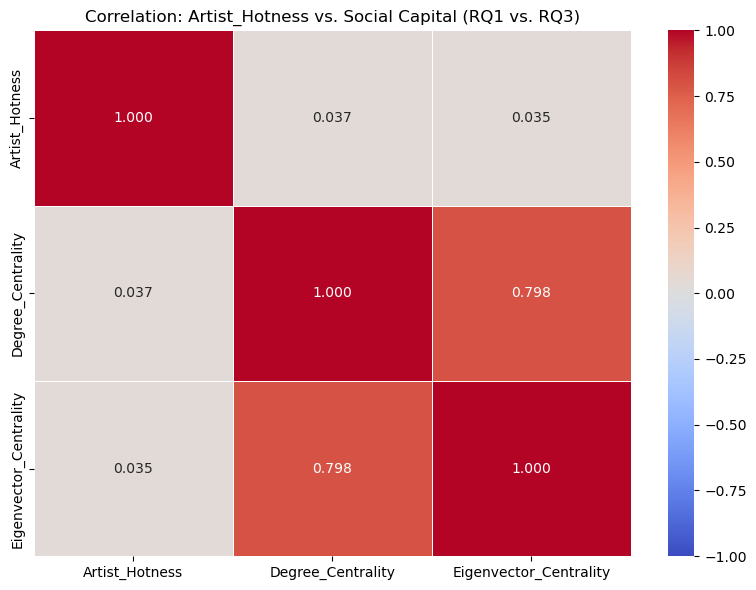

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 读取你刚刚创建的增强版数据集
# (确保这个文件名与你上一步保存的文件名完全一致)
input_file = "Spotify_Model_Ready_Features_Enhanced_RQ2.csv"

try:
    df = pd.read_csv(input_file, sep=';')
    print(f"成功读取文件: {input_file}. Shape: {df.shape}\n")

    # 2. 定义我们关心的三个核心特征
    # Artist_Hotness (来自 RQ1/RQ2)
    # Degree_Centrality (来自 RQ3)
    # Eigenvector_Centrality (来自 RQ3)
    features_of_interest = ['Artist_Hotness', 'Degree_Centrality', 'Eigenvector_Centrality']
    
    # 3. 计算皮尔逊相关系数矩阵
    print("--- 正在计算皮尔逊相关系数... ---")
    
    # 我们只对那些 Artist_Hotness > 0 (即在训练集中出现过的艺人)
    # 和 Degree_Centrality > 0 (即在合作网络中出现过的艺人) 进行计算
    # 这样可以避免大量的0值稀释相关性
    df_filtered = df[(df['Artist_Hotness'] > 0) & (df['Degree_Centrality'] > 0)]
    
    if df_filtered.empty:
        print("错误：过滤后的数据为空，无法计算相关性。")
        print("这可能意味着 'Artist_Hotness' 和 'Degree_Centrality' 之间没有重叠的非零艺人。")
    else:
        print(f"已过滤数据进行相关性计算 (排除了新艺人), 剩余样本: {len(df_filtered)}")
        correlation_matrix = df_filtered[features_of_interest].corr(method='pearson')
        
        print("\n=== 皮尔逊相关系数矩阵 ===\n")
        print(correlation_matrix)

        # 4. (推荐) 绘制热力图以实现可视化
        print("\n--- 正在生成热力图... ---")
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5, vmin=-1, vmax=1)
        plt.title('Correlation: Artist_Hotness vs. Social Capital (RQ1 vs. RQ3)')
        plt.tight_layout()
        
        output_plot = "RQ3_results/hotness_vs_social_capital_correlation.png"
        plt.savefig(output_plot)
        print(f"热力图已保存到: {output_plot}")

except FileNotFoundError:
    print(f"错误: 未找到文件 '{input_file}'。")
except KeyError:
    print(f"错误: 数据中未找到 'Artist_Hotness', 'Degree_Centrality' 或 'Eigenvector_Centrality'。")
    print(f"找到的列: {df.columns.tolist()}")
except Exception as e:
    print(f"发生了一个意外错误: {e}")